<a href="https://colab.research.google.com/github/suzukimain/diffusers_in_Colab/blob/main/diffusers_in_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title   #Step1.セットアップ (Setup) { run: "auto", display-mode: "form"}

import torch,os
#if torch.cuda.device_count()==False:
#  raise RuntimeError("deviceをGPUに変更お願いします")

print("実行中…")
import locale #この2行は非常に重要
locale.getpreferredencoding = lambda: "UTF-8"

Google_driveに接続 = True  # @param {type:"boolean"}
#@markdown Googleドライブに保存したいときにチェックをしてください
from google.colab import drive
import google.colab.drive as drive
if Google_driveに接続:
  Gdrive="GoogleDrive: \033[32m接続成功\033[0m"
  if not drive._os.path.ismount('/content/drive'):
    try:
      drive.mount('/content/drive')
    except:
      Gdrive="GoogleDrive: \033[31m接続失敗\033[0m"
      Google_driveに接続=False
else:
  Gdrive="GoogleDrive: \033[33m接続なし\033[0m"
  if drive._os.path.ismount('/content/drive'):
     drive.flush_and_unmount()
     print("GoogleDriveの接続を解除しました")

import os

#import logging#エラーを非表示に
#logging.getLogger("diffusers").setLevel(logging.ERROR)


need_install=True
try:
  import torch, diffusers ,transformers ,accelerate ,safetensors ,huggingface_hub ,omegaconf
  need_install=False
except:
  need_install=True
if "step1_finish" not in locals():
  need_install=True

if need_install:
    %cd /content
    !git clone https://github.com/alexblattner/modified-euler-samplers-for-sonar-diffusers.git -q
    !git clone https://github.com/huggingface/diffusers.git -q
    %cd diffusers
    !pip install . -q
    !pip install git+https://github.com/suzukimain/diffusers_mod.git -q
    !pip install transformers omegaconf accelerate sacremoses googletrans==3.1.0a0 -q
    import torch
    import diffusers
    import transformers
    import accelerate
    import safetensors
    import huggingface_hub
    import omegaconf

import torch, diffusers ,transformers ,accelerate ,safetensors ,huggingface_hub ,omegaconf
#transformers.utils.move_cache()

import glob
import gc
import time
import sys
import spacy
import codecs
import re
import pickle
import torch
import random
import numpy as np
import googletrans
import ipywidgets as widgets
from PIL import Image,PngImagePlugin
from datetime import datetime
from IPython.display import display, Markdown
from diffusers import (StableDiffusionPipeline, DPMSolverMultistepScheduler,
                       StableDiffusionImg2ImgPipeline, DiffusionPipeline, AutoencoderKL,
                       UNet2DConditionModel, PNDMScheduler,
                       schedulers,TextToVideoZeroPipeline,
                       StableDiffusionInpaintPipeline,
                       StableDiffusionPipelineSafe,
                      )
from diffusers import (
    DDPMScheduler,
    DDIMScheduler,
    PNDMScheduler,
    LMSDiscreteScheduler,
    DPMSolverMultistepScheduler,
)
from diffusers.pipelines.stable_diffusion_safe import SafetyConfig
from transformers import (pipeline, CLIPTextModel, CLIPTokenizer, AutoModel, AutoTokenizer)
from transformers import AutoTokenizer, AutoModelForCausalLM
from googletrans import Translator
import datetime
from IPython.display import display, HTML
from huggingface_hub import hf_hub_download
from safetensors.torch import save_file
from torch import Generator
import imageio
from IPython.display import HTML
from base64 import b64encode
from google.colab import drive
import google.colab.drive as drive

# safety_checker.pyファイルからIFSafetyCheckerクラスをインポート
from diffusers.pipelines.deepfloyd_if.safety_checker import IFSafetyChecker


from diffusers import logging

logging.set_verbosity_error()

%cd /content/modified-euler-samplers-for-sonar-diffusers
sys.path.append( "./EulerANew.py" )
sys.path.append( "./EulerNew.py" )
!python EulerANew.py
!python EulerNew.py
import EulerANew,EulerNew
from EulerANew import EulerA
from EulerNew import Euler

step1_finish=True

if drive._os.path.ismount('/content/drive'):
  Connect_Gdrive="\033[34mGoogleDrive: 接続成功\033[0m"
else:
  Connect_Gdrive="\033[34mGoogleDrive: \033[33m接続なし\033[0m"
print("\n\033[34m___________________________________________\033[0m\n")
print(Connect_Gdrive)
print("\n\033[32mセットアップが完了しました。\033[0m")

実行中…
/content
fatal: destination path 'modified-euler-samplers-for-sonar-diffusers' already exists and is not an empty directory.
fatal: destination path 'diffusers' already exists and is not an empty directory.
/content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
/content/modified-euler-samplers-for-sonar-diffusers

___________________________________________

GoogleDrive: 接続成功

セットアップが完了しました。


In [ ]:
#@title  #Step2.モードの選択 (Mode Selection){display-mode: "form"}

#"\033[31m先にStep.1を実行してください\033[0m"


# @markdown >使用するモデルの切り替え (model change)

model_select = "Counterfeit-V2.5(Anime)(better)" # @param ["stable diffusion-v2.1(basic)", "Counterfeit-V2.5(Anime)(better)", "loliDiffusion(Anime)", "waifu diffusion-v1.4(Anime)", "Anything-v3.0(Anime)", "Anything-v4.5(Anime)", "anything-midjourney-v-4-1(Anime)", "ACertainThing(Anime)", "anime-kawai-diffusion(Anime)", "AB4.5_AC0.2(Anime)", "basil_mix(Anime)", "Counterfeit(Anime)", "Counterfeit-V2.0(Anime)", "chilled_remix(Anime)", "chilled_reversemix(Anime)", "Double-Exposure-Diffusion(Anime)", "EimisAnimeDiffusion_1.0v(Anime)", "7th_Layer(Anime)", "Riga_Collection(Anime)", "Waifu-Diffusers(Anime)", "JWST-Deep-Space-diffusion(space)", "sd-db-epic-space-machine(space_ship)", "spacemidj(space)", "nasa-space-v2(space)", "openjourney-v4(Reality)", "Realistic_Vision_V2.0(Reality)", "meinamix_meinaV10(Reality)", "search"] {allow-input: true}

#削除モデル(使えないもの),"nasa_space_v2(space)","loliDiffusion(Anime)","chilled_remix(Anime)"

#@markdown モデルの選択方法

#@markdown * ボックスの右の三角を押すと出るリストから選択

#@markdown * URLを入力 ( **hugfaceにあるモデルのみ** )

#@markdown * hugface_pathを入力 ( **diffusersのみ** )

#@markdown * ダウンロードしたモデルが保存されているパスを入力

#@markdown *  **search** と入力すると全てのディレクトリから候補を探します。

# @markdown >モードの切り替え (mode change)
mode_select = "Quick" #@param ["Nomal(better)","Quick"]

#@markdown * "Nomal" 品質と生成時間のバランス重視です(fp32)

#@markdown * "Quick" 少し品質が低下する代わりに生成時間が短縮します(fp16)

# @markdown >パイプラインの指定

パイプラインの種類= "txt2img" #@param ["txt2img", "img2img","Inpaint","txt2video","safe"]

# @markdown * txt2img  : テキストから画像

# @markdown * img2img : 画像から画像

# @markdown * Inpaint : 書いた画像に色をつける

# @markdown * txt2video : テキストから動画

# @markdown * safe : より安定して安全な画像の生成ができます(txt2img)

#@markdown >vaeを選択
vaeを指定 = "default(better)" # @param ["default(better)", "waifu-diffusion","Counterfeit-V2.5","anything-v3.0"]
#@markdown defaultを選択した場合、モデルに含まれている本来のvaeを使用します

#@markdown >スケジューラーを変更

Scheduler_select = "ddpm" # @param ["EulerA", "Euler","dpm","ddpm","ddim","pndm","lms"]
if パイプラインの種類=="txt2video" and Scheduler_select!=("ddim" or "pndm"):
  print('txt2videoの場合、Schedulerは"ddim"or"pndm"のみ使用可能です。(Schedulerをddimに設定しました)')
  Scheduler_select="ddim"

# @markdown ノイズの入力に使用するSchedulersを変更します。

# @markdown * EulerA ( EulerAncestralDiscreteScheduler ) : 画像の結果にランダム性をもたらします

# @markdown * Euler (   EulerDiscreteScheduler ) : 画像に統一性をもたせます

#@markdown 上記以外のスケジューラーはmoment関連のパラメータが使用出来ません。

#@markdown * DDPM : 生成速度を多少犠牲にする代わりに画質が高いです。(推奨)

#@markdown >埋め込みを適用
Repo_id_or_path = "" # @param {type:"string"}
weight_name= "" # @param {type:"string"}
token = "" # @param {type:"string"}
#@markdown Repo_id_or_path : hugface_idまたはfile_pathの入力をお願いします。
# @markdown token : 埋め込みを呼び出す場合に"Prompt"または"N_prompt"のいずれかに入力お願いします。
# @markdown weight_name : Repo_idの場合にファイル名前を指定してください


# @markdown >フィルターを調整



# @markdown **注意事項 : 変更する時は注意して下さい**

Filter_off = True  # @param {type:"boolean"}

# @markdown 追記:人が映り込んだだけでフィルタリングされることがあったので追加しました

#@markdown ---

#@markdown >model_selectのsearch選択のみ

入力を飛ばす = False  # @param {type:"boolean"}
input_skip=入力を飛ばす
#@markdown model_selectのsearch機能で、同じモデルファイルを使います。




if "step1_finish" not in locals():
  raise NameError("\033[33m先にStep.1の実行をお願いします\033[0m")

if "count_number" not in locals():
  count_number=0
  input_skip=False

if "model_url" not in locals():
  model_url=""



if input_skip and (model_url is not None) and (model_url!=""):
  try:
    model_select=model_url
  except:
    print("モデルファイルが指定されていません。")
    model_select=model_select

if パイプラインの種類=="safe":
  if Scheduler_select =="EulerA" or Scheduler_select == "Euler":
    Scheduler_select="ddim"
    print('safe_pipelineでは、ソナー付きの"EulerA" or "Euler"を使用すると絵が崩壊するバグが発生しているので、ddimに設定しました。')

model_id =""
model_name =""
can_EN=False
input_url=False
vae_name=""
model_file=""


if vaeを指定 == "waifu-diffusion":
  vae_name="hakurei/waifu-diffusion"

elif vaeを指定 == "Counterfeit-V2.5":
  vae_name= "gsdf/Counterfeit-V2.5"

elif vaeを指定 == "anything-v3.0":
  vae_name= "Linaqruf/anything-v3.0"

#laion/CLIP-ViT-H-14-laion2B-s32B-b79K


if not vaeを指定 == "default(better)":
  vae_change=True
  try:
    vae = AutoencoderKL.from_pretrained(vae_name)
  except:
    vae = AutoencoderKL.from_pretrained(vae_name , subfolder="vae")
else:
  vae=""
  vae_change=False


can_use_components=False#初期値
#isは不可
if "model_check_old" not in  locals():
  model_check_old=str(model_select)
  reuse_model=False
else:
  if model_check_old ==str(model_select):
    reuse_model=True
  else:
    reuse_model=False
  model_check_old=str(model_select)

if "token_dict" not in locals() or reuse_model!=True:
  token_dict=[]


def File_search():
  # 拡張子を指定する
  exts = [".safetensors", ".ckpt"]
  search_path=""
  # 除外対象のパスの終わりを指定する
  exclude = {"safety_checker/model.safetensors",
           "unet/diffusion_pytorch_model.safetensors",
           "vae/diffusion_pytorch_model.safetensors",
           "text_encoder/model.safetensors",
           "safety_checker/model.ckpt",
           "unet/diffusion_pytorch_model.ckpt",
           "vae/diffusion_pytorch_model.ckpt",
           "text_encoder/model.ckpt",
           "root/.chahe"
          }

  # 全てのディレクトリを検索する

  # 絶対パスのリストを作成する
  paths = []
  for root, dirs, files in os.walk("/"):
    for file in files:
        # 指定した拡張子のファイルかどうかチェックする
        if any(file.endswith(ext) for ext in exts):
            path = os.path.join(root, file)
            # 除外対象のパスで終わっていないかチェックする
            if path not in exclude:
              if not path.startswith("/root/.cache"):
                paths.append(path)
  num_path=len(paths)
  # 絶対パスの数を表示する
  if num_path == 0:
    raise FileNotFoundError("\033[33mモデルファイルが見つかりませんでした\033[0m")
  else:
    print(f"モデルファイルの候補が{num_path}個見つかりました。")

  # 絶対パスのリストを番号付きで表示する
  for s, path in enumerate(paths, 1):
    print(f"{s}: {path}")

  # ユーザーに番号を入力させる
  num = int(input(f"番号を入力してください(1〜{num_path}): "))

  # 入力された番号に対応する絶対パスを返す
  if 1 <= num <= len(paths):
    search_path=(paths[num-1])
    print(f"選択されたモデルファイル: {search_path}\n")
    print('設定を変更するが、上記のモデルファイルをそのまま使う場合は、"入力を飛ばす"をオンにするのを推奨します\n')
  else:
    raise TypeError(f"\033[33m無効な文字です。有効な数字: 1〜{len(paths)}\033[0m")
  return search_path


#def print_text():
#  if mode_select == "Nomal(better)":
#     mode_text="mode: Nomal(fp32)\n"
#  else:
#     mode_text="mode: Quick(fp16)\n"
#  return mode_text

def print_format():
  word_format=""
  if パイプラインの種類 == "txt2img":
    word_format="パイプラインの種類: txt2img\n"
  elif パイプラインの種類 == "img2img":
    word_format="パイプラインの種類: img2img\n"
  elif パイプラインの種類 == "txt2video":
    word_format="パイプラインの種類: txt2video"
  elif パイプラインの種類 == "Inpaint":
    word_format="パイプラインの種類: Inpaint"
  elif パイプラインの種類 == "safe":
    word_format="パイプラインの種類: safe"
  return word_format

#mode_text=print_text()
word_format=print_format()


def result():
  if Filter_off == False:
     filter_level = "フィルターの強度:通常"
  else:
     filter_level = "\033[33mフィルターの強度:無効\033[0m"
  return filter_level



device = "cuda" if torch.cuda.is_available() else "cpu"


if "model_url" not in locals():
  model_url=""

def model_select_type_check(model_select,model_url):
  #初期値
  model_url=model_url
  repo_name, model_name, word, branch, file_name = "", "", "", "", ""
  input_url,local_file=False,False
  Error_M1=('''URLを読み込めませんでした。この機能がサポートしている形式は次の通りです。
            形式:"https://huggingface.co/<repo_name>/<model_name>/blob/main/<path_to_file>.safetensors"
            例1: "https://huggingface.co/gsdf/Counterfeit-V3.0/blob/main/Counterfeit-V3.0.safetensors"
            例2: "https://huggingface.co/runwayml/stable-diffusion-v1-5/blob/main/v1-5-pruned.ckpt"
            補足:huggingfaceにあれば、diffusersのタグがついていないモデルでも、ほとんどの場合使用できます。
            ''')
  Error_M2=('''hugface_pathを読み込めませんでした。この機能がサポートしている形式は次の通りです。
            形式: <repo_name>/<model_name>"
            例1: "Linaqruf/anything-v3.0"
            例2: "stabilityai/stable-diffusion-2-1"
            補足1:diffusersのタグがついているモデルのみを対象としています
            補足2: 次のモデルのみ、モデル名のみで読み込めます。
            (下のモデル名をコピー&ペースト、または、model_selectの右側の三角を押すと出てくるドロップダウンからお選びください。)

            "stable diffusion-v2.1"
            "waifu diffusion-v1.4"
            "Anything-v3.0"
            "anything-midjourney-v-4-1"
            "Anything-v4.5"
            "AB4.5_AC0.2"
            "basil_mix"
            "Waifu-Diffusers"
            "Double-Exposure-Diffusion"
            "openjourney-v4"
            "ACertainThing"
            "Counterfeit-V2.0"
            "Counterfeit-V2.5"
            "7th_Layer"
            "EimisAnimeDiffusion_1.0v"
            "Riga_Collection"
            "anime-kawai-diffusion"
            "Realistic_Vision_V2.0"
            "meinamix_meinaV10"
            "loliDiffusion"
            ''')
  Error_M3=('''指定されたパスを認識できませんでした。次をお試しください
            ・ファイルのパスが存在するかの確認
            ・空白が混入していないかの確認(pathの最後に半角空白が意図せずつくことがあります)
            ・"\"や、拡張子以外の"."などの特殊記号が含まれているかの確認(認識されない可能性があります)
            ''')
  if model_select=="search":
    search_path=File_search()
    model_url=search_path
    input_url=True
    local_file=True

  elif model_select.startswith("https://huggingface.co/"):
    try:
      trimmed_url = model_select.replace("https://huggingface.co/", "")
        # 区切り文字 "/" で分割
      segments = trimmed_url.split("/")
        # 変数に割り当て
      repo_name, model_name, word , branch, file_name = segments[:5]
    except:
      raise ValueError(Error_M1)
    model_url=model_select
    input_url=True

#  elif model_select.startswith("."or"/")and model_select.endswith(".safetensors"or".ckpt"or".bin"):
  elif os.path.isfile(model_select):
        input_url=True
        model_url=model_select
        local_file=True
  #diffusersライブラリのみ
  elif "/" in model_select and model_select.count("/") == 1:
    model_select_keyword = model_select.split("/")
    repo_name, model_name = model_select_keyword[:2]
  else:
    raise ValueError(Error_M2)
  return model_name, input_url,model_url,local_file




#   モデルの選択肢と対応する情報を辞書に保存する
#<model_select>:(<model_id>,<model_name>,<can_EN>,<input_url>,<model_url>)can_EN=can use embed
model_dict = {
    "stable diffusion-v2.1(basic)" : ("stabilityai/stable-diffusion-2-1", "stable_diffusion-v2.1", False, False, ""),
    "waifu diffusion-v1.4(Anime)": ("hakurei/waifu-diffusion", "waifu_diffusion-v1.4", False, False, ""),
    "Anything-v3.0(Anime)": ("Linaqruf/anything-v3.0", "Anything-v3.0", True, False, ""),
    "anything-midjourney-v-4-1(Anime)": ("Joeythemonster/anything-midjourney-v-4-1", "anything-midjourney-v-4-1", True, False, ""),
    "Anything-v4.5(Anime)": ("shibal1/anything-v4.5-clone", "Anything-v4.5", False, False, ""),
    "AB4.5_AC0.2(Anime)": ("aioe/AB4.5_AC0.2", "AB4.5_AC0.2", False, False, ""),
    "basil_mix(Anime)": ("nuigurumi/basil_mix", "basil_mix", True, False, ""),
    "Waifu-Diffusers(Anime)": ("Nilaier/Waifu-Diffusers", "Waifu-Diffusers", True, False, ""),
    "Double-Exposure-Diffusion(Anime)": ("joachimsallstrom/Double-Exposure-Diffusion", "Double-Exposure-Diffusion", True, False, ""),
    "openjourney-v4(Reality)": ("prompthero/openjourney-v4", "openjourney-v4", True, False, ""),
    "ACertainThing(Anime)": ("JosephusCheung/ACertainThing", "ACertainThing", True, False, ""),
    "Counterfeit-V2.0(Anime)": ("gsdf/Counterfeit-V2.0", "Counterfeit-V2.0", True, False, ""),
    "Counterfeit-V2.5(Anime)(better)": ("gsdf/Counterfeit-V2.5", "Counterfeit-V2.5", True, False, ""),
    "chilled_remix(Anime)":("chilled_remix","chilled_remix" ,False,True,"https://huggingface.co/sazyou-roukaku/chilled_remix/blob/main/chilled_remix_v2.safetensors"),
    "chilled_reversemix(Anime)":("chilled_reversemix","chilled_reversemix" ,False,True,"https://huggingface.co/sazyou-roukaku/chilled_remix/blob/main/chilled_reversemix_v2.safetensors"),
    "7th_Layer(Anime)": ("syaimu/7th_test", "7th_Layer", True, False, ""),
    "EimisAnimeDiffusion_1.0v(Anime)": ("eimiss/EimisAnimeDiffusion_1.0v", "EimisAnimeDiffusion_1.0v", True, False, ""),
    "JWST-Deep-Space-diffusion(space)" : ("dallinmackay/JWST-Deep-Space-diffusion", "JWST-Deep-Space-diffusion", False, False, ""),
    "Riga_Collection(Anime)": ("natsusakiyomi/Riga_Collection", "Riga_Collection", True, False, ""),
    "anime-kawai-diffusion(Anime)": ("Ojimi/anime-kawai-diffusion", "anime-kawai-diffusion", True, False, ""),
    "Realistic_Vision_V2.0(Reality)": ("SG161222/Realistic_Vision_V2.0", "Realistic_Vision_V2.0", True, False, ""),
    "sd-db-epic-space-machine(space_ship)" : ("rabidgremlin/sd-db-epic-space-machine", "sd-db-epic-space-machine", False, False, ""),
    "spacemidj(space)" : ("Falah/spacemidj", "spacemidj", False, False, ""),
    "meinamix_meinaV10(Reality)": ("namvuong96/civit_meinamix_meinaV10", "meinamix_meinaV10", True, False, ""),
    "nasa-space-v2(space)" : ("sd-dreambooth-library/nasa-space-v2-768", "nasa-space-v2", False, False, ""),
    "loliDiffusion(Anime)": ("loliDiffusion","loliDiffusion" ,True,True,"https://huggingface.co/JosefJilek/loliDiffusion/blob/main/loliDiffusionV0.10.10_AOM2-SFW_1.0M4-CLIP_VAE_PURIFIED.safetensors"),
    #ここからほぼ同じ
    "stable diffusion-v2.1" : ("stabilityai/stable-diffusion-2-1", "stable_diffusion-v2.1", False, False, ""),
    "waifu diffusion-v1.4": ("hakurei/waifu-diffusion", "waifu_diffusion-v1.4", False, False, ""),
    "Anything-v3.0": ("Linaqruf/anything-v3.0", "Anything-v3.0", True, False, ""),
    "anything-midjourney-v-4-1": ("Joeythemonster/anything-midjourney-v-4-1", "anything-midjourney-v-4-1", True, False, ""),
    "Anything-v4.5": ("shibal1/anything-v4.5-clone", "Anything-v4.5", False, False, ""),
    "AB4.5_AC0.2": ("aioe/AB4.5_AC0.2", "AB4.5_AC0.2", False, False, ""),
    "basil_mix": ("nuigurumi/basil_mix", "basil_mix", True, False, ""),
    "Waifu-Diffusers": ("Nilaier/Waifu-Diffusers", "Waifu-Diffusers", True, False, ""),
    "Double-Exposure-Diffusion": ("joachimsallstrom/Double-Exposure-Diffusion", "Double-Exposure-Diffusion", True, False, ""),
    "openjourney-v4": ("prompthero/openjourney-v4", "openjourney-v4", True, False, ""),
    "ACertainThing": ("JosephusCheung/ACertainThing", "ACertainThing", True, False, ""),
    "Counterfeit-V2.0": ("gsdf/Counterfeit-V2.0", "Counterfeit-V2.0", True, False, ""),
    "Counterfeit-V2.5": ("gsdf/Counterfeit-V2.5", "Counterfeit-V2.5", True, False, ""),
    "chilled_remix":("chilled_remix","chilled_remix" ,False,True,"https://huggingface.co/sazyou-roukaku/chilled_remix/blob/main/chilled_remix_v2.safetensors"),
    "chilled_reversemix":("chilled_reversemix","chilled_reversemix" ,False,True,"https://huggingface.co/sazyou-roukaku/chilled_remix/blob/main/chilled_reversemix_v2.safetensors"),
    "7th_Layer": ("syaimu/7th_test", "7th_Layer", True, False, ""),
    "EimisAnimeDiffusion_1.0v": ("eimiss/EimisAnimeDiffusion_1.0v", "EimisAnimeDiffusion_1.0v", True, False, ""),
    "JWST-Deep-Space-diffusion" : ("dallinmackay/JWST-Deep-Space-diffusion", "JWST-Deep-Space-diffusion", False, False, ""),
    "Riga_Collection": ("natsusakiyomi/Riga_Collection", "Riga_Collection", True, False, ""),
    "sd-db-epic-space-machine" : ("rabidgremlin/sd-db-epic-space-machine", "sd-db-epic-space-machine", False, False, ""),
    "spacemidj" : ("Falah/spacemidj", "spacemidj", False, False, ""),
    "anime-kawai-diffusion": ("Ojimi/anime-kawai-diffusion", "anime-kawai-diffusion", True, False, ""),
    "Realistic_Vision_V2.0": ("SG161222/Realistic_Vision_V2.0", "Realistic_Vision_V2.0", True, False, ""),
    "nasa-space-v2" : ("sd-dreambooth-library/nasa-space-v2-768", "nasa-space-v2", False, False, ""),
    "meinamix_meinaV10": ("namvuong96/civit_meinamix_meinaV10", "meinamix_meinaV10", True, False, ""),
    "loliDiffusion": ("loliDiffusion","loliDiffusion" ,True,True,"https://huggingface.co/JosefJilek/loliDiffusion/blob/main/loliDiffusionV0.9.3_AOM2-SFW_0.8M7.8-CLIP_VAE_PURIFIED.safetensors")
  }

def diffusers_model_select(model_url):
  # 初期値
  model_id,model_name,model_url,local_file="","","",""
  can_EN=False
  input_url=False
  # 辞書からモデルの情報を取得する
  if model_select in model_dict:
      model_id,model_name,can_EN,input_url,model_url = model_dict[model_select]
  else:
      model_name,input_url,model_url,local_file = model_select_type_check(model_select,model_url)
  return model_id,model_name,can_EN,input_url,model_url,local_file

model_id,model_name,can_EN,input_url,model_url,local_file=diffusers_model_select(model_url)

EN='''埋め込み: 有効\n有効化の鍵: <EasyNegative>,<bad-hands>\n
※埋め込みを使用する場合、「有効化の鍵」を＜＞ごとコピー＆ペーストしてください'''
# 辞書にファイル名とキーのワードのペアを保存する
#<file_name>:<token>

# StableDiffusion(メインのモジュール)パイプライン設定


# パイプラインのクラスを定義する



def pipe_create(input_url,model_url,model_id):
    if input_url:
          base_pipe = StableDiffusionPipeline.from_single_file(
              model_url,torch_dtype=torch.float16 if mode_select=="Quick" else torch.float32
          ).to("cuda")
    else:
          base_pipe = StableDiffusionPipeline.from_pretrained(
            model_id,torch_dtype=torch.float16 if mode_select=="Quick" else torch.float32
          ).to("cuda")
    return base_pipe

if reuse_model==False or "base_pipe" not in locals():
  base_pipe=pipe_create(input_url,model_url,model_id)

class make_main_pipe:
  def __init__(self,base_pipe,Scheduler_select,vae):
    self.base_pipe=base_pipe
    self.Scheduler_select=Scheduler_select
    self.vae=vae
    self.pipe_args_setup = {}
    self.stetas={}
    txt2img_pipe,img2img_pipe,txt2video_pipe,Inpaint_pipe,safe_pipe=None,None,None,None,None
  def main_pipe_set(self):
    txt2img_pipe,img2img_pipe,txt2video_pipe,Inpaint_pipe,safe_pipe=None,None,None,None,None
    textual_inversion_dict ={
        "EasyNegativeV2.safetensors": "EasyNegative",
        "bad-hands-5.pt": "bad-hands",
        }
    Scheduler_dict={
        "ddpm":("ddpmS",DDPMScheduler),
        "ddim":("ddim_S",DDIMScheduler),
        "pndm":("pndm_S",PNDMScheduler),
        "lms" :("lms_S",LMSDiscreteScheduler),
        "dpm": ("dpm_S",DPMSolverMultistepScheduler),
        "EulerA":("EulerA_S",EulerA),
        "Euler":("Euler_S",Euler),
        }
    pipe_class_dict={
        "txt2img":("txt2img_pipe",StableDiffusionPipeline),
        "img2img":("img2img_pipe",StableDiffusionImg2ImgPipeline),
        "txt2video":("txt2video_pipe",TextToVideoZeroPipeline),
        "Inpaint":("Inpaint_pipe",StableDiffusionInpaintPipeline),
        "safe":("safe_pipe",StableDiffusionPipelineSafe),
        }
    self.Scheduler_name,self.Scheduler_class = Scheduler_dict[self.Scheduler_select]
    scheduler = self.Scheduler_class.from_config(self.base_pipe.scheduler.config)
    self.stetas["vae"]=self.vae if not vaeを指定=="default(better)" else self.base_pipe.vae
    self.stetas["text_encoder"]=self.base_pipe.text_encoder
    self.stetas["tokenizer"]=self.base_pipe.tokenizer
    self.stetas["unet"]=self.base_pipe.unet
    self.stetas["scheduler"]=scheduler
    self.stetas["safety_checker"]=self.base_pipe.safety_checker if not Filter_off else None
    self.stetas["requires_safety_checker"]=False if not Filter_off else True
    self.stetas["feature_extractor"]=self.base_pipe.feature_extractor

    self.main_name,self.pipe_class=pipe_class_dict[パイプラインの種類]
    #とりあえず
    if パイプラインの種類 == "txt2img":
      txt2img_pipe =self.pipe_class(**self.stetas).to("cuda")
    elif パイプラインの種類 == "img2img":
      img2img_pipe =self.pipe_class(**self.stetas).to("cuda")
    elif パイプラインの種類 == "txt2video":
      txt2video_pipe =self.pipe_class(**self.stetas).to("cuda")
    elif パイプラインの種類 =="Inpaint":
      Inpaint_pipe =self.pipe_class(**self.stetas).to("cuda")
    elif パイプラインの種類 =="safe":
      safe_pipe =self.pipe_class(**self.stetas).to("cuda")
    else:
      raise ValueError("想定外の処理がされました")

#"EasyNegativeV2.safetensors": "EasyNegative",
   #     "bad-hands-5.pt": "bad-hands",
    if can_EN:
      if not パイプラインの種類=="safe":
        try:#weight_name=,token=がないとエラーになる
        #  for weight_name, token in textual_inversion_dict.items():
        #    self.main_name.load_textual_inversion("embed/negative", weight_name=weight_name, token=token)
          if パイプラインの種類 == "txt2img":
            txt2img_pipe.load_textual_inversion("embed/negative", weight_name="EasyNegativeV2.safetensors", token="EasyNegative")
            txt2img_pipe.load_textual_inversion("embed/negative", weight_name="bad-hands-5.pt", token="bad-hands")

          elif パイプラインの種類 == "img2img":

            img2img_pipe.load_textual_inversion("embed/negative", weight_name="EasyNegativeV2.safetensors", token="EasyNegative")
            img2img_pipe.load_textual_inversion("embed/negative", weight_name="bad-hands-5.pt", token="bad-hands")


          elif パイプラインの種類 == "txt2video":
            #txt2video_pipe =self.pipe_class(**self.stetas).to("cuda")
            txt2video_pipe.load_textual_inversion("embed/negative", weight_name="EasyNegativeV2.safetensors", token="EasyNegative")
            txt2video_pipe.load_textual_inversion("embed/negative", weight_name="bad-hands-5.pt", token="bad-hands")


          elif パイプラインの種類 =="Inpaint":
            #Inpaint_pipe =self.pipe_class(**self.stetas).to("cuda")
            Inpaint_pipe.load_textual_inversion("embed/negative", weight_name="EasyNegativeV2.safetensors", token="EasyNegative")
            Inpaint_pipe.load_textual_inversion("embed/negative", weight_name="bad-hands-5.pt", token="bad-hands")



        #"EasyNegativeV2.safetensors"
        except ValueError:
            #print("\033[31m埋め込みのロードに失敗しました。\033[0m")

            print("既に埋め込みは適用されています。")
            EN="\033[33m埋め込み: このモデルでは使用不可です\033[34m"
      else:
        print("\033[31mこのパイプラインでは埋め込みがサポートされていません\033[0m")
        EN="\033[33m埋め込み: このモデルでは使用不可です\033[34m"
    else:
      EN="\033[33m埋め込み: このモデルでは使用不可です\033[0m"
    if model_select=="txt2img":
      txt2img_pipe.enable_vae_tiling()

    return txt2img_pipe,img2img_pipe,txt2video_pipe,Inpaint_pipe,safe_pipe
  # パイプラインの名前を返すメソッド
  #def pipe_name(self):
  #  return f"{self.model_name}_{self.pipe_class.__name__}"
MMP=make_main_pipe(base_pipe,Scheduler_select,vae)
txt2img_pipe,img2img_pipe,txt2video_pipe,Inpaint_pipe,safe_pipe=MMP.main_pipe_set()
# パイプラインのオブジェクトを作成する
#pipe_cls = pipe_cls(vae, model_id, model_name, can_EN, input_url, model_url, torch,Scheduler_select)
# パイプラインのセットアップと作成を行う
#pipe_cls.pipe_setup()
#pipe=pipe_cls.pipe_create()
#pipe=pipe_cls.return_pipe()
#上を消す


class add_textual(make_main_pipe):
  def __init__(self,Repo_id_or_path,weight_name,token,txt2img_pipe,img2img_pipe,txt2video_pipe,Inpaint_pipe,safe_pipe):
     self.txt2img_pipe=txt2img_pipe
     self.img2img_pipe=img2img_pipe
     self.txt2video_pipe=txt2video_pipe
     self.Inpaint_pipe=Inpaint_pipe
     self.safe_pipe=safe_pipe
     self.sta={}
  def load_textual(self):
    Custom_tokens=""
    do=True
    if not (Repo_id_or_path and token)=="":
      if not os.path.isfile(Repo_id_or_path):
        if not weight_name=="":
          raise TypeError("'weight_name' の入力をお願いします" )
        else:
          self.sta["weight_name"]=weight_name
    else:
      do=False
    if do:
      try:
        if パイプラインの種類 == "img2img":
          img2img_pipe.load_textual_inversion(Repo_id_or_path,**self.sta, token=token)
        elif パイプラインの種類 == "txt2video":
          txt2video_pipe.load_textual_inversion(Repo_id_or_path, **self.sta, token=token)
        elif パイプラインの種類 =="Inpaint":
          Inpaint_pipe.load_textual_inversion(Repo_id_or_path, **self.sta, token=token)
        else:
          txt2img_pipe.load_textual_inversion(Repo_id_or_path,**self.sta, token=token)
        print(f"トークン{token}")
        token_dict.append(token)
        a = ','.join([x for x in token_dict if x not in ['[', ']', "'"]])
        Custom_tokens=f"カスタムトークン: {a}\n"

      except ValueError:
        if token in token_dict:
          print("すでに埋め込みは適用済みです")
          a = ','.join([x for x in token_dict if x not in ['[', ']', "'"]])
          Custom_tokens=f"カスタムトークン: {a}\n"
        else:
          print("カスタム埋め込みの適用に失敗しました")
    return Custom_tokens

ct=add_textual(Repo_id_or_path,weight_name,token,txt2img_pipe,img2img_pipe,txt2video_pipe,Inpaint_pipe,safe_pipe)
Custom_tokens=ct.load_textual()



filter_level=result()

if input_url:
  model_file=model_file
if local_file:
  model_print=(f"model_file_path: {model_url}")
else:
  model_print=(f"model_name: {model_name}")

def k():
  global fin
  fin=True
  return fin
fin=k()
#\033[31mが赤、\033[33mが黄色、\033[34mが青、\033[32mが緑、\033[0mが白
# "\033[32m" は緑色に変更するための"ANSI Escape Code"であり、"\033[0m"はデフォルトの文字色に戻すためのコードです。
# \033[38;2;0;255;255m　水色
#\033[38;2;74;229;110m　黄緑
MS="____________________________________________________________________________"
Finish1="\033[32m画像生成の準備が出来ました。手順3に移ってください。\033[0m"
Finish2="\033[32m(Now that the image generation is ready, please proceed to step 3.)\033[0m"
status=(f"""
\n\033[34m{MS}\n\n
{model_print}\n\n
Scheduler: {Scheduler_select}\n\n
{word_format}\n
{EN}\n
{Custom_tokens}\n
{filter_level}\n\n
{Finish1}
\033[0m""")
if Scheduler_select!="Euler"and Scheduler_select!="EulerA":
  print('\n\nmomentは、"Scheduler_selectが "Euler"、"EulerA"のいずれかでのみ有効です。\n')
print(status)

In [ ]:
#@title  #Step3.画像の生成  (iamge generation){display-mode: "form"}
#from re import escape
#@markdown #自動生成

自動で条件を決めて生成 = False #@param {type:"boolean"}
auto_G=自動で条件を決めて生成
#@markdown **操作がよくわからない方はチェックをつけて下さい。自動で生成します**

#@markdown >この機能の詳細
#@markdown  * 詳細設定を推奨の値に設定
#@markdown  * プロンプトが入力されていない場合、初期値として "1girl" / "1woman" のいずれかを入力

#@markdown  >次の機能をオンにします
#@markdown   * 画面に表示
#@markdown   * 画像の質を上げるプロントを追加する
#@markdown   * プロンプトアシストを使う ( MagicPrompt )
#@markdown   * 推奨するネガティブプロントを使用
#@markdown   * 条件をメタデーターとして追加する


#@markdown

#@markdown -----

# @markdown >生成したい枚数を入力してください　/ Please enter the number of images you want to generate here.
生成する枚数 = 1 #@param {type:"slider", min:1, max:100, step:1}
枚数制限なし = False #@param {type:"boolean"}
num_imgs=生成する枚数
#if 生成する枚数 <= 0 or isinstance(生成する枚数, float):
  #  print("\033[31m警告:無効な数字が入力された為デフォルトの1枚に設定しました\033[0m")
  #  生成する枚数 = 1
#if 生成する枚数 is None:
 #   print("\033[31m警告:無効な形式な為デフォルトの1枚に設定しました\033[0m")
#    生成する枚数 = 1

# @markdown ------

# @markdown  >生成する画像の条件を**英語で**入力してください　(Please input the conditions for generating images in **English**.)

Prompt = "smail,1girl, white hair, medium hair, cat ears, looking at viewer, :3, cute,white_dress" # @param ["smail,1girl, white hair, medium hair, cat ears, looking at viewer, :3, cute,white_dress", "Please draw a beautiful Mount Fuji with the sun rising from the summit", "Earth, space, high resolution"] {allow-input: true}
画像の質を上げるプロントを追加する = True #@param {type:"boolean"}
add_good_prompt=画像の質を上げるプロントを追加する
#プロンプトアシストを使う = True #@param {type:"boolean"}
日本語入力 = False #@param {type:"boolean"}
JP_INPUT=日本語入力

# @markdown >**プロンプトの例**
# @markdown * cute, cat
# @markdown * Earth, space, high resolution
# @markdown * Please draw a beautiful Mount Fuji with the sun rising from the summit
# @markdown * smail,1girl, white hair, medium hair, cat ears, looking at viewer, :3, cute,white_dress

# @markdown >**ランダムワード**
# @markdown  * {cat,dog},cute ＝ "cat , cute" / "dog , cute"
# @markdown  * color,{blue,red,green} ＝ "color , blue" / "color , red" / "color , green"

# @markdown ------
# @markdown >プロンプトアシスタントの選択
text_generate_model= "None" #@param ["None","MagicPrompt-Stable-Diffusion","anime-anything-promptgen-v2"]

# @markdown アニメ調の画像に適したアシスタントは " anime-anything-promptgen-v2 "

# @markdown 多目的のアシスタントは " MagicPrompt-Stable-Diffusion "

# @markdown 使用しない場合は " None " の選択をお願いします

条件を統一する = False #@param {type:"boolean"}

#@markdown 最初の画像のプロンプトを繰り返し使用します

# @markdown ------

# @markdown >画像を入力として送リます。

入力する画像 = "" #@param {type:"string"}
# @markdown パイプラインの種類を "img2img" or"Inpaint"とした場合のみに使えます


# @markdown ------

#@markdown #詳細設定

seed値 = -1 # @param {type:"number"}
seed_number=seed値
guidance_scale = 8.5 #@param {type:"slider", min:5, max:15, step:0.5}
momentum = 0.8 #@param {type:"slider", min:0, max:1, step:0.1}
momentum_hist = 0.6 #@param {type:"slider", min:-1, max:1, step:0.1}
history_d = "rand_init" # @param ["rand_new", "rand_init"]
拡散ステップ = 30  # @param {type:"number"}
## @markdown >img2img**以外**
縦の大きさ = "512" #@param ["480","512","600", "768","800", "1080","1152", "1440","1920", "3840","4000","7680"]
横の大きさ = "512" #@param ["480","512","600", "768","800", "1080","1152", "1440", "1920", "3840","4000","7680"]

# @markdown >img2img、Inpaintのみ
strength = 0.8 # @param {type:"slider", min:0, max:1, step:0.1}
#@markdown >txt2video のみ
video_length= 8  # @param {type:"number"}
#@markdown >safeのみ
safety_level = "MAX" # @param ["MAX","STRONG","MEDIUM","WEAK"]
#@markdown 強さ ： WEAK＜MEDIUM＜STRONG＜MAX

if auto_G:
  guidance_scale=8.5
  momentum=0.95
  momentum_hist=0.75
  拡散ステップ=35
  縦の大きさ=512
  横の大きさ=512
  strength=0.8
  print("自動的にパラメーターが指定されました。オフにしたい場合は'自動で生成'のチェックを外してください")


sd_step=拡散ステップ

height = int(縦の大きさ)
width = int(横の大きさ)

#@markdown >用語の説明

# @markdown * seed ("-1"以上) / seed値を指定します。0の場合ランダムな数字を割り当てます。

# @markdown * guidance_scale (5≦15 推奨"7.5") / promptの強さの値です。強すぎるとノイズが発生する一方、弱すぎると絵が崩壊します。

# @markdown * history_d ("rand_new", "rand_init" )  推奨:"rand_new

# @markdown * moment(0.1≦1.0 ) 推奨"0.8"

# @markdown * momentum_hist(-1.0≦1.0)  推奨"0.2"

#@markdown * 拡散ステップ(1≦1000 推奨"50") / 計算をする回数を指定します。回数を減らすほど生成速度が速くなります

# @markdown * 縦・横の大きさ ( 推奨"512" ) / 大きくすればするほど生成速度が遅くなります(img2img、Inpaint**以外のみ**)

# @markdown ------

# @markdown >必要であればネガティブプロンプトを入力してください。人物を生成するときにおすすめです

# @markdown よくわからない方ボタンを押してください。おすすめのネガティブプロントを使います

## @markdown (If necessary, please enter a negative prompt. It is recommended for generating characters.)

N_prompt = "elf ears:1.0,logo:1.1,character:2.0"  # @param {type:"string"}
推奨するネガティブプロントを使用 = True #@param {type:"boolean"}
# @markdown ネガティブプロンプトとは、**ネガティブな要素を除く**ものです。

## @markdown (Negative prompts are used to exclude negative elements from an image. For example, you can use a negative prompt to exclude low quality images or images that are not beautiful.)

# @markdown ------

#@markdown >保存する先を指定します

## @markdown (If you would like to specify a location to save the generated image, please enter the path.)

保存する先のパス = ""  # @param {type:"string"}
#@markdown デフォルトでは /content/Generated_images に保存されます。なければ作るようになっています。

# @markdown >file_nameを指定します

#@markdown デフォルトは "GIMG-{number}" です

file_name = "" #@param {type:"string"}

#@markdown >file_nameの特殊トークンについて

#@markdown ファイル名にパラメータなどの値を入力できます。

#@markdown * {prompt} : Prompt

#@markdown * {seed} : seed値

#@markdown * {model_name} : model_name

#@markdown * {g_scale} : guidance_scale

#@markdown * {time} : 現在時刻

#@markdown * {number} : 生成した回数

# @markdown ------

# @markdown >グリッド画像の設定

横の画像数 = 5 # @param {type:"slider", min:1, max:10, step:1}
num_grid=int(横の画像数)
##@markdown 0の場合は、自動で設定します。

# @markdown ------

# @markdown >オプション

画像を表示 = True  # @param {type:"boolean"}
グリッド画像を表示 = True  # @param {type:"boolean"}
画像情報を表示 = True  # @param {type:"boolean"}
条件をメタデーターとして追加する = True  # @param {type:"boolean"}

#@markdown ---

警告メッセージを非表示 = False #@param {type:"boolean"}
if "make_main_pipe" not in locals():
  raise NameError("先にstep.3の実行をお願いします")
if "can_EN" not in locals():
  can_EN = False

#@markdown ---

#@markdown >実験的機能
safety_level_change = False  # @param {type:"boolean"}
select_safety_level = 0.5 # @param {type:"slider", min:0, max:1, step:0.1}

# @markdown デフォルトは "0.5"です低いほどフィルターが緩くなります

IFSafetyChecker.safety_level = select_safety_level # クラス変数の値を0.9に変更


if not add_good_prompt and not 警告メッセージを非表示:
  print('\033[33m"画像の質を上げるプロントを追加する"がオフになっています。')

def run_html_js(path,moji):
    num=len(path)
    # 現在の日付と時刻を取得
    import datetime
    now_a = datetime.datetime.now()
    # 文字列に変換し、フォーマット指定子で数字だけを取り出す
    datetime = now_a.strftime("%Y%m%d%H%M%S")
    html_dis = f'''
    <style>
      #clipborad-text-{datetime} {{
        border: none; /* 枠線を消す */
        color: #0ff; /* 文字色を青にする */
        font-size: 16px; /* 文字の大きさを16pxにする */
      }}
    </style>
    <span style="color: #4ae56e" font-size:16px>{moji}</span> <!-- <p>タグを<span>タグに変更 -->
    <input type="text" value="{path}" id="clipborad-text-{datetime}" size="{num}" readonly> <!-- size属性とid属性を追加 -->
    <button id="copy-button-{datetime}" onclick="copyToClipboard('{datetime}')">Copy</button> <!-- id属性とonclick属性を追加 -->
    '''
    js_code = '''
    function copyToClipboard(datetime) {
      var copyText = document.getElementById("clipborad-text-" + datetime); // datetimeを結合
      var copyButton = document.getElementById("copy-button-" + datetime); // datetimeを結合
      copyText.select();
      navigator.clipboard.writeText(copyText.value);
      document.execCommand("copy");
      copyButton.textContent = "Copied!"; // ボタンの文字を変更
      setTimeout(function() {
        copyButton.textContent = "Copy"; // 1秒後に元に戻す
        }, 1000);
    }
    '''
    display(HTML(html_dis))
    display(HTML('<script>{}</script>'.format(js_code)))


def img_set(path):
  init_image = Image.open(path)
  init_image = init_image.resize((height, width))
  return init_image


class Scheduler_setup(make_main_pipe):
  def moment_set(self,Scheduler_select,vae):
    if Scheduler_select=="Euler" or Scheduler_select=="EulerA":
      # choose from [0, 'rand_new', 'rand_init']
      self.main_name.scheduler.history_d =history_d
      # number should be between -1 and 1
      self.main_name.scheduler.momentum = momentum
      # number should be between -1 and 1
      self.main_name.scheduler.momentum_hist = momentum_hist
sc_set=Scheduler_setup(base_pipe,Scheduler_select,vae)
sc_set.moment_set(Scheduler_select,vae)
if (not Prompt.endswith(",")) and (Prompt is not None):
  Prompt=Prompt+","

img_dir=False
img_dict = []
img_dir_num=1
img_path=""
if パイプラインの種類=="img2img":
  if os.path.isfile(入力する画像) and 入力する画像.endswith ==".png"or".jpg"or".jpeg":
    img_path=入力する画像
  elif os.path.isdir(入力する画像):
    # フォルダ内のファイル名を取得する
    files = os.listdir(入力する画像)
    # 画像の拡張子を定義する
    img_ext = [".jpg", ".png",".jpeg"]
    # フォルダ内のファイルをループする
    for file in files:
        # ファイルの拡張子を取得する
        ext = os.path.splitext(file)[1]
        # 拡張子が画像のものかどうかチェックする
        if ext in img_ext:
            # 画像のパスをimg_dictに追加する
            img_path = os.path.join(入力する画像, file)
            img_dict.append(img_path)
    # img_dictが空でないかどうかチェックする
    if img_dict or len(img_dict)>1:
      img_dir=True
      img_dir_num=len(img_dict)
  else:
    raise FileNotFoundError('入力する画像が見つかりませんでした。画像を入力しない場合は、Step.1のパイプラインの種類を"txt2img"に変更お願いします')


if JP_INPUT:
  tr = Translator()
  Prompt_2_a = tr.translate(Prompt, src="ja", dest="en").text
  Prompt_2=Prompt_2_a
else:
  Prompt_2=Prompt
class txt_model_setup:
  def __init__(self,Prompt,Prompt_2,add_good_prompt,auto_G,JP_INPUT,text_generate_model,N_prompt):
    self.text_model_name=None
    self.pipe_name=None
    Prompt=Prompt
    self.N_prompt=N_prompt
    Prompt_2=Prompt_2
    self.add_good_prompt=add_good_prompt
    self.auto_G=auto_G
    self.tokens=None
    JP_INPUT=JP_INPUT
    self.txt_model_name=""
    self.txt_pipe_name=""
    self.good_word = "masterpiece:2.0,best quality,high quality,"
    text_generate_model=text_generate_model

  def option(self):
    if self.add_good_prompt or self.auto_G:
      self.mini_prompt=True
    else:
      self.mini_prompt=False
    return self.mini_prompt

  def get_tokens_as_list(self,word_list):
      "Converts a sequence of words into a list of tokens"
      tokens_list = []
      for word in word_list:
          tokenized_word = self.tokenizer_with_prefix_space([word], add_special_tokens=False).input_ids[0]
          tokens_list.append(tokenized_word)
      return tokens_list


#symmetrical_clear_eyes
#self.txt_pipe_name.model.config.pad_token_id = self.txt_pipe_name.model.config.eos_token_id

  def p_token(self,Prompt):
    self.tokens = int(len(self.tokenizer.tokenize(Prompt)))
    return self.tokens
  def txt_G(self,Prompt_2):
    n_word=["EasyNegative","bat_hands","Loss of eye highlights","simple background","Fingers fused together","Writing Sweet Fingers","bad hands","bad legs","worst quality","low quality","Not five fingers","blurred","Missing finger","Simple background","Cat with deformed face","medium quality","purple hair","Loss of eye highlights","Fingers fused together","Writing Sweet Fingers","deleted","lowres","Low quality animals","deformed animals","hands emerging from impossible places","bad anatomy","more than three limbs hands/legs","low resolution","blurry","absurdres","pixelated","sketchy","nonsensical anatomy","unrealistic pose","mosaic","unclear details","distorted colors","unrealistic proportions","poor quality","fuzzy","missing head:1.6","out of focus","hazy","grainy","text","error","missing fingers:0.9","extra digit","fewer digits","cropped","jpeg artifacts","signature","watermark","username","standard quality","bad feet_hand_finger_leg_eye","bad","text font ui","bad shadow","poorly drawn","black-white","ugly","duplicate","mutation","mutilated","malformed mutated:1.1","malformed:1.1","The background is incoherent","simple background","low-quality background","low background","bad body","long body","broken limb","anatomical nonsense","extra limbs","missing limb","incorrect limb","multiple heads","twisted head","poorly drawn face","1 unit with multiple heads:1.3","heads together:1.0","abnormal eye:1.2 proportion","cropped:1.0","bad eyes","fused eyes","poorly drawn eyes","bad mouth","poorly drawn mouth","bad tongue","too long tongue","bad ears","poorly drawn ears","extra ears","heavy ears","long neck","too thick neck","bad neck","bad breasts","missing arms","disappearing arms","extra arms","three arms:2.0","mutated hands and fingers","fused hand","missing fingers","extra digits","huge thighs","disappearing thigh","missing thighs","extra thighs","bad feet","huge calf","disappearing legs","bad gloves","fused gloves","beard","artist name","text watermark","unnatural","obviously wrong","distorted face","floating hair","floating body parts","severed body parts","incorrect leg position","deformed","fused body and hands","disregard of physics","distorted shape","doll-like object not present in the image","body fusion","abnormal fingers","fingers resembling fish fins","dot eyes","unclear background","mosaic","body bending","incorrect leg-to-torso ratio","excessively large breasts","unsettling appearance","eyes filled with solid color","lack of lower body","splitting","creepy doll-like appearance","distorted eyes","lines on the skin","legs bending in unnatural directions","abnormal finger count","missing arms","floating hands","lack of nose or mouth","incorrect body part ratios","bad","longbody","lowres","bad anatomy","bad hands","missing fingers","Distorted eye contour","Missing part from the ankles onward","extra digit","fewer digits","split wings","Vampire wings floating in the air","bad wing","wonder egg priority","egg priority","demon"]
    if not N_prompt=="":
      words = N_prompt.split(",")
      n_word.extend(words)
    bad_words_ids=self.get_tokens_as_list(n_word)
    self.tokens=self.p_token(Prompt)
    if self.mini_prompt==True:
      self.max_length_1=64
    else:
      self.max_length_1=74
    self.max_length=self.max_length_1-self.tokens

    #self.good_word = "masterpiece:2.0,clear eyes:1.3,best quality,high quality,"
    inputs = self.tokenizer([Prompt_2], return_tensors="pt")
    output_ids = self.model.generate(inputs["input_ids"], max_new_tokens=self.max_length,
                            num_beams=4,
                            early_stopping=True ,
                            do_sample=True,
                            top_k=7 ,
                            temperature=0.7,
                            bad_words_ids=bad_words_ids,
                            pad_token_id =50256,
                            eos_token_id=50256,
                           )
    Prompt_4_I=self.tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
    # 辞書の作成


     # 辞書の単語を置換
    af_text=""#初期値
    for np_word in n_word:
      af_text = Prompt_4_I.replace(np_word, "")

    # カンマの重複を修正
    Prompt_4_P = af_text.replace(",,", ",")

    if self.mini_prompt==True:
      Prompt_4=self.good_word+Prompt_4_P
    else:
      Prompt_4=Prompt_4_P
    return Prompt_4

  def easy_prompt(self,Prompt_2,text_generate_model):
    if self.auto_G:
      text_generate_model="MagicPrompt-Stable-Diffusion"
    txt_pipe_dict={"MagicPrompt-Stable-Diffusion":("Gustavosta/MagicPrompt-Stable-Diffusion","MagicPrompt_base","MagicPrompt_tokenizer","MagicPrompt_with"),
                   "anime-anything-promptgen-v2":("FredZhang7/anime-anything-promptgen-v2","AnythingPrompt_base","AnythingPrompt_tokenizer","AnythingPrompt_with"),
                  "None":("","","","")
              }
    self.txt_model_name,self.model,self.tokenizer,self.tokenizer_with_prefix_space = txt_pipe_dict[text_generate_model]
    # Prompt_2に含まれる全ての{}の中身をリストにする    contents = re.findall("\{(.*?)\}", Prompt_2)
    # リストの要素数をカウントする変数
    #if Prompt_2 in ("{"and"}"):
    contents = re.findall("\{(.*?)\}", Prompt_2)
    count = 0
    for content in contents:
      # []の中身が空白やNULLでないかチェックする
        if not content or len(content) == 0:
        # 空白やNULLの場合はスキップする
          continue
        # []の中身を,で区切ってリストに変換
        lst = content.split(",")
        # リストからランダムに一つの要素を選ぶ
        choice = random.choice(lst)
        # []ごと選んだ要素に置き換える
        # 最初の一つだけ置き換えるためにcount=1とする
        Prompt_2 = re.sub("\{.*?\}", choice, Prompt_2, count=1)
        # リストの要素数をカウントアップする
        count += 1

    if text_generate_model == "None": # テキスト生成モデルを使わない場合
      self.good_word = "masterpiece:2.0,best quality,high quality,"
      text_model_name ="" # テキストモデル名を空にする
      if self.mini_prompt:
        Prompt_4=self.good_word+Prompt_2
      else:
        Prompt_4 = Prompt_2 # プロンプトをそのまま返す

    else:
      try:
        Prompt_4 = self.txt_G(Prompt_2)
      except:
        self.model = AutoModelForCausalLM.from_pretrained(self.txt_model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(self.txt_model_name)
        self.tokenizer_with_prefix_space = AutoTokenizer.from_pretrained(self.txt_model_name, add_prefix_space=True)

        #,num_beams=3,early_stopping=False ,do_sample=True
        #self.txt_pipe_name=pipeline('text-generation', model=self.txt_model_name,num_beams=4,early_stopping=True ,do_sample=True, top_k=4 , temperature=0.7)

        Prompt_4 = self.txt_G(Prompt_2)
    return Prompt_4,self.tokens
#,early_stopping=Trueを削除


  def main_task(self):
    mini_prompt=self.option()
    #Prompt_2=self.word_preprocessing(JP_INPUT,Prompt)
    Prompt_4,self.tokens=self.easy_prompt(Prompt_2,text_generate_model)
    #print('\b'*71)
    #prompt=Prompt_4
    return Prompt_4


tms=txt_model_setup(Prompt,Prompt_2,add_good_prompt,auto_G,JP_INPUT,text_generate_model,N_prompt)
Prompt_4 = tms.main_task()




if 推奨するネガティブプロントを使用 or 自動で条件を決めて生成 :
  if can_EN:
    おすすめのネガティブプロント = ",<EasyNegative,bat_hands:1.3>,Loss of eye:1.5,Fingers fused together:1.3,Writing Sweet Fingers:2.0,bad hands:2.0,bad legs:2.0,worst quality:2.0, low quality:2.0,Not five fingers.:2.0,blurred,Missing finger:1.7,Simple_background:2.0,Cat with deformed face:1.3 ,medium quality, purple hair,Loss of eye highlights:1.5,Fingers fused together:1.3,Writing Sweet Fingers:2.0 ,deleted:0.5, lowres,Low quality animals, deformed animals ,hands emerging from impossible places:1.7, bad anatomy, more than three limbs hands/legs:1.5, low resolution, blurry, absurdres,pixelated, sketchy, nonsensical anatomy, unrealistic pose, mosaic, unclear details, distorted colors, unrealistic proportions, poor quality, fuzzy, missing head:1.6, out of focus, hazy, grainy, text, error, missing fingers:0.9, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, standard quality, bad feet_hand_finger_leg_eye, bad, text font ui, bad shadow, poorly drawn, black-white, ugly, duplicate, mutation, mutilated, malformed mutated:1.1, malformed:1.1, The background is incoherent, simple background, low-quality background, low background, bad body, long body, broken limb, anatomical nonsense, extra limbs, missing limb, incorrect limb, multiple heads, twisted head, poorly drawn face, 1 unit with multiple heads:1.3, heads together:1.0, abnormal eye:1.2 proportion, cropped:1.0, bad eyes, fused eyes, poorly drawn eyes, bad mouth, poorly drawn mouth, bad tongue, too long tongue, bad ears, poorly drawn ears, extra ears, heavy ears, long neck, too thick neck, bad neck,  bad breasts, missing arms, disappearing arms, extra arms, three arms:2.0, mutated hands and fingers, fused hand, missing fingers, extra digits, huge thighs, disappearing thigh, missing thighs, extra thighs, bad feet, huge calf, disappearing legs, bad gloves, fused gloves, beard, artist name, text watermark, unnatural, obviously wrong, distorted face, floating hair, floating body parts, severed body parts, incorrect leg position, deformed, fused body and hands, disregard of physics, distorted shape, doll-like object not present in the image, body fusion, abnormal fingers, fingers resembling fish fins, dot eyes, unclear background, mosaic, body bending, incorrect leg-to-torso ratio, excessively large breasts, unsettling appearance, eyes filled with solid color, lack of lower body, splitting, creepy doll-like appearance, distorted eyes, lines on the skin, legs bending in unnatural directions, abnormal finger count, missing arms, floating hands, lack of nose or mouth,, incorrect body part ratios, bad, longbody, lowres, bad anatomy, bad hands, missing fingers,  Distorted eye contour, Missing part from the ankles onward, extra digit, fewer digits, split wings, Vampire wings floating in the air, bad wing, comic,chainsaw man,demon"
  else:
    おすすめのネガティブプロント = ",Loss of eye :1.5,Fingers fused together:1.3,Writing Sweet Fingers:2.0,bad hands:2.0,bad legs:2.0,worst quality:2.0, low quality:2.0,Not five fingers:2.0,blurred,Simple_background:2.0,Missing finger:1.7,Cat with deformed face:1.3 ,medium quality, purple hair,Loss of eye highlights:1.5,Fingers fused together:1.3,Writing Sweet Fingers:2.0 ,deleted:0.5, lowres,Low quality animals, deformed animals ,hands emerging from impossible places:1.7, bad anatomy, more than three limbs hands/legs:1.5, low resolution, blurry, absurdres,pixelated, sketchy, nonsensical anatomy, unrealistic pose, mosaic, unclear details, distorted colors, unrealistic proportions, poor quality, fuzzy, missing head:1.6, out of focus, hazy, grainy, text, error, missing fingers:0.9, extra digit, fewer digits, cropped, jpeg artifacts, signature, watermark, username, standard quality, bad feet_hand_finger_leg_eye, bad, text font ui, bad shadow, poorly drawn, black-white, ugly, duplicate, mutation, mutilated, malformed mutated:1.1, malformed:1.1, The background is incoherent, simple background, low-quality background, low background, bad body, long body, broken limb, anatomical nonsense, extra limbs, missing limb, incorrect limb, multiple heads, twisted head, poorly drawn face, 1 unit with multiple heads:1.3, heads together:1.0, abnormal eye:1.2 proportion, cropped:1.0, bad eyes, fused eyes, poorly drawn eyes, bad mouth, poorly drawn mouth, bad tongue, too long tongue, bad ears, poorly drawn ears, extra ears, heavy ears, long neck, too thick neck, bad neck,  bad breasts, missing arms, disappearing arms, extra arms, three arms:2.0, mutated hands and fingers, fused hand, missing fingers, extra digits, huge thighs, disappearing thigh, missing thighs, extra thighs, bad feet, huge calf, disappearing legs, bad gloves, fused gloves, beard, artist name, text watermark, unnatural, obviously wrong, distorted face, floating hair, floating body parts, severed body parts, incorrect leg position, deformed, fused body and hands, disregard of physics, distorted shape, doll-like object not present in the image, body fusion, abnormal fingers, fingers resembling fish fins, dot eyes, unclear background, mosaic, body bending, incorrect leg-to-torso ratio, excessively large breasts, unsettling appearance, eyes filled with solid color, lack of lower body, splitting, creepy doll-like appearance, distorted eyes, lines on the skin, legs bending in unnatural directions, abnormal finger count, missing arms, floating hands, lack of nose or mouth,, incorrect body part ratios, bad, longbody, lowres, bad anatomy, bad hands, missing fingers,  Distorted eye contour, Missing part from the ankles onward, extra digit, fewer digits, split wings, Vampire wings floating in the air, bad wing, comic,chainsaw man,demon"
else:
  おすすめのネガティブプロント =""
  if not 警告メッセージを非表示:
    print('\033[33m"推奨ネガティブプロンプト"がオフになっています。\033[0m')


negative_prompt2 = N_prompt + おすすめのネガティブプロント

if 枚数制限なし:
  生成する枚数=100000


def image_grid(imgs,cols): #縦よこ
  all_num=len(imgs)
  if all_num!=0:
    am=0
    w, h = imgs[0].size
    rows,b= divmod(all_num,cols)
    if b!=0:
      rows+=1
      am=cols-b
      white_img = Image.new("RGB", (w,h), (255, 255, 255))
      #T=rows*cols-len(imgs)
      for x in range(am):
        imgs.append(white_img)
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  else:
    grid=None
    print("グリッド画像に使用可能な画像がありません。")
  return grid




if 保存する先のパス:
  if not Google_driveに接続:
    if "/content/drive/MyDrive" in 保存する先のパス:
      image_save_path="/content/生成した画像"
      print("\033[31mGoogleドライブに接続されていないためデフォルトのパスに保存しました\033[0m")
    else:
      image_save_path=保存する先のパス
  else:
    image_save_path=保存する先のパス
else:
  image_save_path="/content/Generated_images"
if not os.path.exists(image_save_path):
      os.makedirs(image_save_path)

if not os.path.exists("/content/Grid_img"):
      os.makedirs("/content/Grid_img")



if seed_number is None:
  seed_number=-1
#  seed = random.randint(1,1000000)

#generator = torch.Generator("cuda").manual_seed(seed)


def seed_set(seed_number):
  global seed
  if seed_number==-1:
    seed = random.randint(1,1000000)
  else:
    seed=seed_number

  return seed
seed=seed_set(seed_number)



def path_token_video(Prompt_4,seed_number,model_name,guidance_scale,file_name,image_save_path):
  global L
  try:
    L+=1
  except:
    L=1
  file_name_old=""
  if not file_name:
    file_name=("Gvideo")
  now = datetime.datetime.now()
  file_name_encoded = codecs.encode(file_name, 'utf-8')
  file_name_decoded = codecs.decode(file_name_encoded, 'utf-8')
  path_d = {"{prompt}":Prompt_4,"{seed}": seed, "{model_name}": model_name, "{g_scale}": guidance_scale,"{time}":now ,"{number}":L}
  for key, value in path_d.items():
     # valueという引数に渡す値をstr関数で文字列型に変換する
    file_name_old = file_name_decoded.replace(key, str(value))
  while True:
    file_new=(f"{file_name_old}-{L}.mp4")
    file_test = os.path.join(image_save_path , file_new)
    if os.path.exists(file_test):
      L+=1
    else:
       path_new=file_test
       file_new=file_new
       break
  return path_new,file_new


def path_token_img(Prompt_4,seed_number,model_name,guidance_scale,file_name,image_save_path):
  global z
  try:
    z+=1
  except:
    z=1
  file_name_old=""
  if not file_name:
    file_name=("GIMG")
  now = datetime.datetime.now()
  file_name_encoded = codecs.encode(file_name, 'utf-8')
  file_name_decoded = codecs.decode(file_name_encoded, 'utf-8')
  path_d = {"{prompt}":Prompt_4,"{seed}": seed, "{model_name}": model_name, "{g_scale}": guidance_scale,"{time}":now ,"{number}":z}
  for key, value in path_d.items():
    # valueという引数に渡す値をstr関数で文字列型に変換する
    file_name_old = file_name_decoded.replace(key, str(value))
  #file_name_old=path_token_img(file_new,seed_number,model_name,guidance_scale,file_name)    file_new= (f"{file_name_old}.png")
  while True:
     file_new=(f"{file_name_old}-{z}.png")
     file_test = os.path.join(image_save_path , file_new)
     if os.path.exists(file_test):
       z+=1
     else:
       path_new=file_test
       file_new=file_new
       break
  return path_new,file_new



def play_mp4(path_new):
  mp4 = open(path_new, 'rb').read()
  data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
  HTML_code=(f"""
             <video width="70%" height="70%" controls>
                   <source src="{data_url}" type="video/mp4">
             </video>""")
  #未テストのため
  try:
    display(HTML(HTML_code))
  except:
    display(HTML('<script>{}</script>'.format(HTML_code)))



generator = torch.Generator(device)

class generate_class:
  def __init__(self,img_dir,img_path,img_dict,seed,generator,num_grid,Prompt_4,image_save_path,sd_step,model_name,file_name):
    seed=seed
    generator=generator
    self.num_grid=num_grid
    if not img_dir:
      self.st=生成する枚数
    else:
      self.st=生成する枚数*(len(img_dict))
    Prompt_4=Prompt_4
    image_save_path=image_save_path
    self.image_save_path=image_save_path
    sd_step=sd_step
    model_name=model_name
    file_name=file_name
    grid_img=None
    self.img_dir=img_dir
    self.img_path=img_path
    self.img_dict=img_dict
    self.j=1
    self.init_image=None
    self.grid_imgs=[]
    self.generate_time_all_after=0
    self.nsfw_content_detected=None


  def generate_images(self,seed,generator,Prompt_4,image_save_path,sd_step,model_name,file_name,txt2img_pipe,img2img_pipe,Inpaint_pipe,safe_pipe):
    now_2=datetime.datetime.now()
    try:
      y+=1
    except:
      y=1
    T=1
    i=1
    generate_time_all=0
    generate_start_time=0
    generate_end_time=0
    generator = torch.Generator(device)
    for i in range(生成する枚数):
      path_new,file_new=path_token_img(Prompt_4,seed_number,model_name,guidance_scale,file_name,image_save_path)

      if not 条件を統一する:
        if i >=1:
          Prompt_4 = tms.main_task()
      if seed_number==-1:
        seed=seed_set(seed_number)
      now = datetime.datetime.now()
      date_str = now.strftime("%Y-%m-%d_UTC-%H:%M:%S")
      path = os.path.join(image_save_path, file_name)
      generate_start_time = time.time()
      generator.manual_seed(seed)
      if パイプラインの種類 == "img2img":
        output = img2img_pipe(Prompt_4,image=self.init_image, strength=strength,negative_prompt=negative_prompt2, num_inference_steps=sd_step,guidance_scale=guidance_scale,generator=generator)
      elif パイプラインの種類 == "Inpaint":
        output = Inpaint_pipe(Prompt_4,image=self.init_image, strength=strength,negative_prompt=negative_prompt2, num_inference_steps=sd_step,height=height,width=width,guidance_scale=guidance_scale,generator=generator)
      elif パイプラインの種類 == "safe":
        safety_level_dict={"MAX":SafetyConfig.MAX,
                   "STRONG":SafetyConfig.STRONG,
                   "MEDIUM":SafetyConfig.MEDIUM,
                   "WEAK":SafetyConfig.WEAK,
                   }
        self.safety_level_choise = safety_level_dict[safety_level]
        output = safe_pipe(Prompt_4,negative_prompt=negative_prompt2, guidance_scale=guidance_scale, num_inference_steps=sd_step,height=height,width=width,generator=generator,**self.safety_level_choise  )
      else:
        output = txt2img_pipe(Prompt_4, negative_prompt=negative_prompt2, guidance_scale=guidance_scale, num_inference_steps=sd_step,height=height,width=width,generator=generator)
      self.nsfw_content_detected=output.nsfw_content_detected
      make_image=output.images[0]
      if self.nsfw_content_detected is None:
        bloke=False
      else:
        if False in self.nsfw_content_detected:
          bloke=False
        else:
          bloke=True
      info = make_image.info
      if 条件をメタデーターとして追加する or 自動で条件を決めて生成:
        metadata = {
            "Seed": seed,
            "model": model_name,
            "G_scale":guidance_scale,
            "D_step":sd_step,
            "Prompt": Prompt_4,
            "n_prompt":negative_prompt2
           }
        pnginfo = PngImagePlugin.PngInfo()
        for key, value in metadata.items():
            pnginfo.add_text(key, str(value))
        make_image.save(path_new, pnginfo=pnginfo)
      else:
        make_image.save(path_new)
      generate_end_time = time.time()
      generate_time = generate_end_time - generate_start_time
      generate_time_all += generate_time
      generate_time_after=("{:.2f}s".format(generate_time))
      if 枚数制限なし:
          print(f"\033[34m画像生成が完了しました ({self.j}/∞)  {generate_time_after}")
      else:
          print(f"\033[34m画像生成が完了しました ({self.j}/{self.st})  {generate_time_after}")
      if 画像情報を表示:
          print(f"seed値:\033[38;2;0;255;255m {seed}")
          print(f"\033[34mファイルの名前: \033[32m{file_new}\033[0m")
          run_html_js(path_new,"保存先のパス: ")
          print("\033[34m上記のようになります。ご確認ください\033[0m")
      imgN = Image.open(path_new)
      if not bloke:
        self.grid_imgs.append(imgN)
      elif bloke and 警告メッセージを非表示==False:
          print("ブロックされました")
      else:
        pass
      if bloke==False and (画像を表示 or auto_G):
        display(imgN)
      else:
        imgN=False
      if bloke==False and 画像情報を表示:
        print(f'\033[92mプロンプト:  {Prompt_4}\033[0m\n')  # "\033[38;2;135;206;235m" はスカイブルー    "\033[38;2;255;165;0m"はオレンジ
      img = Image.open(path_new)
      self.j+=1
    self.generate_time_all_after=generate_time_all/生成する枚数
    #remainder=1
  def grid_task(self):
    try:
      y=y
    except:
      y=1
    while True:
      grid_test_path=os.path.join(self.image_save_path,f"grid_imgs-{y}.png")
      if os.path.exists(grid_test_path):
        y+=1
      else:
        grid_path=grid_test_path
        break

    if 生成する枚数!=1:
      grid = image_grid(self.grid_imgs,cols=self.num_grid)
      if grid is not None:
        grid.save(grid_path)
        grid_img = Image.open(grid_path)
        if グリッド画像を表示 or auto_G:
          run_html_js(grid_path,"グリッド画像のパス: ")
          #print(f"\033[34mgrid_save_path: \033[32m{grid_path}\033[0m")
          display(grid_img)
    print("\033[38;2;135;206;235m1枚あたりの生成時間の平均: {:.2f}s\033[0m".format(self.generate_time_all_after))

  def generate_video(self,seed,generator,Prompt_4,image_save_path,sd_step,model_name,file_name,txt2video_pipe):
    T=1
    generate_time=0
    generate_start_time=0
    generate_end_time=0
    grid_imgs=[]
    chunk_size=4
    path_new,file_new=path_token_video(Prompt_4,seed_number,model_name,guidance_scale,file_name,image_save_path)
    now = datetime.datetime.now()
    date_str = now.strftime("%Y-%m-%d_UTC-%H:%M:%S")
    path = os.path.join(image_save_path, file_name)
    generate_start_time = time.time()
    generator = torch.Generator(device=device)
    result = []
    chunk_ids = np.arange(0, video_length, chunk_size - 1)
    for T in range(len(chunk_ids)):
          print(f"Processing chunk {T + 1} / {len(chunk_ids)}")
          ch_start = chunk_ids[T]
          ch_end = video_length if T == len(chunk_ids) - 1 else chunk_ids[T + 1]
          # Attach the first frame for Cross Frame Attention
          frame_ids = [0] + list(range(ch_start, ch_end))
          # Fix the seed for the temporal consistency
          generator.manual_seed(seed)
          output = txt2video_pipe(prompt=Prompt_4, video_length=len(frame_ids),num_inference_steps=sd_step,t0=(sd_step-5),t1=(sd_step-3) ,negative_prompt=negative_prompt2, guidance_scale=guidance_scale,height=height,width=width,generator=generator, frame_ids=frame_ids)
          result.append(output.images[1:])

    # Concatenate chunks and save
    result = np.concatenate(result)
    result = [(r * 255).astype("uint8") for r in result]
    imageio.mimsave(path_new, result, fps=4)
    generate_end_time=time.time()
    generate_time=generate_end_time-generate_start_time

    print(f"\033[34m動画生成が完了しました  {generate_time}s")
    if 画像情報を表示:
        print(f"\033[34mseed値:\033[32m {seed}")
        print(f"\033[34mファイルの名前:( \033[32m{file_new})\033[0m")
        run_html_js(path_new,"動画ファイルのパス: ")
        print("\033[34m上記のようになります。ご確認ください\033[0m")
    play_mp4(path_new)
      #print("\033[38;2;135;206;235m1つあたりの生成時間の平均: {:.2f}s\033[0m".format(generate_time_all_after))

  def main_t(self,seed,generator,num_grid,Prompt_4,image_save_path,sd_step,model_name,file_name,txt2img_pipe,img2img_pipe,Inpaint_pipe,safe_pipe):
    #print("do")
    if self.img_dir:
      if パイプラインの種類=="Inpaint"or"img2img":
        self.img_path=self.img_path
        self.init_image=img_set(self.img_path)
        self.generate_images(seed,generator,Prompt_4,image_save_path,sd_step,model_name,file_name,txt2img_pipe,img2img_pipe,Inpaint_pipe,safe_pipe)
      else:
        for img_path in self.img_dict:
          self.init_image=img_set(img_path)
          self.generate_images(seed,generator,Prompt_4,image_save_path,sd_step,model_name,file_name,txt2img_pipe,img2img_pipe,Inpaint_pipe,safe_pipe)
    else:
      self.generate_images(seed,generator,Prompt_4,image_save_path,sd_step,model_name,file_name,txt2img_pipe,img2img_pipe,Inpaint_pipe,safe_pipe)
    self.grid_task()


generate_cls=generate_class(img_dir,img_path,img_dict,seed,generator,num_grid,Prompt_4,image_save_path,sd_step,model_name,file_name)
if パイプラインの種類=="txt2video":
  generate_cls.generate_video(seed,generator,Prompt_4,image_save_path,sd_step,model_name,file_name,txt2video_pipe)
else:
  generate_cls.main_t(seed,generator,num_grid,Prompt_4,image_save_path,sd_step,model_name,file_name,txt2img_pipe,img2img_pipe,Inpaint_pipe,safe_pipe)

In [ ]:
#@title メモリの初期化(Beta) {display-mode: "form"}

import gc
import torch

variable_names = ["base_pipe","txt2img_pipe","img2img_pipe","txt2video_pipe","Inpaint_pipe","safe_pipe", "tokenizer"]

for name in variable_names:
    if name in globals():
      del globals()[name]
    if name in locals():
      del locals()[name]

torch.cuda.empty_cache()
gc.collect()

In [ ]:
#@title 埋め込みを学習 {display-mode: "form"}

学習で使用するトークン = "" # @param {type:"string"}
概念を説明する単語 = "" # @param {type:"string"}
学習ステップ = 50   # @param {type:"number"}

入力する画像フォルダ = "" # @param {type:"string"}
出力するフォルダ = "" # @param {type:"string"}
概念のタイプ = "style" # @param ["style","object"]
ベースモデル = "runwayml/stable-diffusion-v1-5" # @param ["runwayml/stable-diffusion-v1-5","stabilityai/stable-diffusion-2-1"]

出力ファイル名 = "" # @param {type:"string"}


#@markdown ---

終了したらランタイムを切断 = False # @param {type:"boolean"}
#@markdown sd1.5系列とsd2.1系列では埋め込みに互換性がありません。

driveに接続 = True # @param {type:"boolean"}

# @markdown >用語の説明
# @markdown * placeholder_token : 学習内で、使用するトークンです。新しい概念を入力します。
# @markdown * initializer_token : 新しい概念が何であるかを要約する単語です。
import os
from google.colab import drive
drive_cn=driveに接続
if driveに接続:
  if not drive._os.path.ismount('/content/drive'):
    try:
      drive.mount('/content/drive')
    except:
      print("ドライブの接続に失敗しました。")
      drive_cn=False



if  drive_cn==False and "/content/drive/MyDrive" in 出力するフォルダ:
  raise TypeError("Googleドライブに接続されていないため、ドライブに保存できません。")

if not os.path.isdir(入力する画像フォルダ):
  raise FileNotFoundError("画像フォルダが存在しません")

if 出力するフォルダ is None:
  raise FileNotFoundError("結果を出力するフォルダを入力してください")



os.makedirs(出力するフォルダ,exist_ok=True)


try:
  import diffusers,transformers
except:
  !pip install transformers -q
  import transformers
  %cd /content
  !git clone https://github.com/huggingface/diffusers
  %cd diffusers
  !pip install . -q


if "setup_txt" not in locals():
  %cd /content/diffusers/examples/textual_inversion
  !pip install -r ./requirements.txt -q
  setup_txt=True

import accelerate,torchvision,transformers,ftfy ,diffusers


%cd /content/diffusers/examples/textual_inversion


if ベースモデル=="runwayml/stable-diffusion-v1-5":
  size=512
else:
  size=768

#exportは使用不可
%env pretrained_model_name_or_path=$ベースモデル
%env train_data_dir=$入力する画像フォルダ
%env learnable_property=$概念のタイプ
%env placeholder_token=$学習で使用するトークン
%env initializer_token=$概念を説明する単語
%env resolution=$size
%env max_train_steps=$学習ステップ
%env output_dir=$出力するフォルダ

#--learning_rate=5  \
#--mixed_precision="fp16" \
#learning_rateは整数
!accelerate launch textual_inversion.py \
  --pretrained_model_name_or_path=$pretrained_model_name_or_path \
  --train_data_dir=$train_data_dir \
  --learnable_property=$learnable_property \
  --placeholder_token=$placeholder_token \
  --initializer_token=$initializer_token \
  --resolution=$resolution \
  --train_batch_size=4 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=$max_train_steps \
  --lr_scheduler="constant" \
  --learning_rate=5  \
  --lr_warmup_steps=0 \
  --output_dir=$output_dir

base=os.path.join(出力するフォルダ,"learned_embeds.safetensors")
if not 出力ファイル名=="":
  after_name=出力ファイル名+".safetensors"
  after=os.path.join(出力するフォルダ,after_name)
  if os.path.exists(base):
    os.rename(base,after)
  else:
    print("埋め込みファイルが見つかりませんでした。")
else:
  after=base

print(f"""\033[34m
学習が終了しました
path: {after}\033[0m
""")

if 終了したらランタイムを切断:
  from google.colab import runtime
  print("ランタイムを切断中...")
  runtime.unassign()

In [ ]:
#@title 画像のメタデータを見る  {display-mode: "form"}
from PIL import Image, PngImagePlugin
import os
image_metadata_path = "/content/IMG_2142.png" #@param {type:"string"}
if not os.path.exists(image_metadata_path):
  raise FileNotFoundError("ファイルが見つかりませんでした")
try:
  output_info = Image.open(image_metadata_path).info
except:
  raise FileNotFoundError("画像を読み込めませんでした")

try:
  print("seed: "+output_info["Seed"]+"\n")
  print("diffusion_step: "+output_info["D_step"]+"\n")
  print("guidance_scale: "+output_info["G_scale"]+"\n")
  print("model_name : "+output_info["model"]+"\n")
  print("prompt: "+output_info["Prompt"]+"\033[0m\n")
except:
  print("\033[31mメタデーターが見つかりませんでした\033[0m")

In [ ]:
#@title  グリッド画像の分割  (iamge generation){display-mode: "form"}
from PIL import Image
import os
import sys
import math

### 各定数の設定
# 縦方向分割数

# 分割元ファイルパス
input_path = "" # @param {type:"string"}
output_dir = "" # @param {type:"string"}
縦の分割回数 = 1 # @param {type:"number"}
横の分割回数 = 3 # @param {type:"number"}
#@markdown >heightとwidthは2以上の自然数の入力をお願いします
height=縦の分割回数
width=横の分割回数
base_img_path=input_path


if base_img_path=="" or  output_dir == "":
  raise TypeError("pathが未入力です")
if output_dir is not dir:
   output_dir = os.path.dirname(output_dir)

def is_positive_integer(value):
    try:
        value = int(value)  # 整数に変換
        if value > 0:  # 1以上の場合は True を返す
            return True
        else:
            return False
    except ValueError:  # ValueError が発生した場合は False を返す
        return False

if not is_positive_integer(height) or is_positive_integer(width):
  raise TypeError("heightとwidthは、2以上の自然数である必要があります。")

def ImgSplit(im,w,h):
    # 読み込んだ画像の高さと幅を指定分割数で割る
    HEIGHT = h / height
    WIDTH = w / width

    # 縦の分割枚数
    for h1 in range(height):
        # 横の分割枚数
        for w1 in range(width):
            w2 = w1 * WIDTH
            h2 = h1 * HEIGHT
            yield im.crop((w2, h2, WIDTH + w2, HEIGHT + h2))

#if __name__ == '__main__': このセルが直接実行された場合
    # 画像の読み込み
im = Image.open(base_img_path)
w = im.size[0]
h = im.size[1]
length = math.log10(height * width) + 1
os.makedirs(output_dir, exist_ok=True)
for number, ig in enumerate(ImgSplit(im,w,h), 1):
    # 出力
    ig.save(output_dir + "/" + str(number).zfill(int(length)) + ".PNG", "PNG")
print(f"\033[34m分割が完了しました: {output_dir}\033[0m")

In [ ]:
#@title  ダウンロード{display-mode: "form"}
#@markdown >ファイル or ディレクトリを指定してダウンロードします。


from google.colab import files
import shutil
import os
path = "/content/Generated_images/GIMG-27.png" #@param {type:"string"}

# 最後が特定の単語であるかをチェックする
if path.endswith(".png" or ".jpg"):
  try:
    files.download(path)
    print("\033[32mダウンロードが正常に完了しました")
  except:
    print("\033[31m指定された画像が見つかりませんでした\033[0m")
elif path.endswith(".mp4"):
  try:
    files.download(path)
    print("\033[32mダウンロードが正常に完了しました")
  except:
    print("\033[31m指定された動画ファイルが見つかりませんでした\033[0m")
else:
  try:
    zip_number+=1
  except:
    zip_number=1
  zip_name=f"Generated_images-No.{zip_number}"
  zip_save_dir=os.path.join("/content",zip_name)
  zippath=zip_save_dir+".zip"
  try:
    shutil.make_archive(zip_save_dir, "zip", images_save_dir_path)
    files.download(zippath)
    print("\033[32mzipファイルへ圧縮が正常に完了しました")
    print(f'zipファイル名前は\033[34m"{zip_name}"\033[32mですご確認ください\033[0m')
  except:
    zip_number-=1
    print("\033[31m指定されたディレクトリが見つかりませんでした\033[0m")

In [ ]:
#@title 画像変換 {display-mode: "form"}
import os
from PIL import Image
import sys
input_path = "" #@param {type:"string"}
output_path="" #@param {type:"string"}
Change_mode = "png2jpg" # @param ["png2jpg", "jpg2png"]

#@markdown * png2jpg :png画像をjpg画像に変換します。


#@markdown * jpg2png :jpg画像をpng画像に変換します。

if not os.path.exists(input_path):
  #raise FileNotFoundError('\033[33m指定された "dir"または"file" が見つかりませんでした。\033[0m')
  sys.exit('"input_path"にdirまたはfileのパスを入力お願いします。')

if not input_path.endswith(".png" or ".jpg" or ".jpeg"):
  if output_path=="":
    # 保存先のディレクトリパスを作成
    save_dir_path = input_path +"-" +Change_mode
  else:
    save_dir_path=output_path
  # 保存先のディレクトリが存在しない場合は作成する
  if not os.path.exists(save_dir_path):
    os.makedirs(save_dir_path)

  # ディレクトリ内のファイルを取得
  file_list = os.listdir(input_path)

  # ファイルごとに処理を行う
  for file_name in file_list:
    # ファイルのパスを作成
    file_path = os.path.join(save_dir_path, file_name)

    # ファイルの拡張子を取得
    file_extension = os.path.splitext(file_name)[1]
    if Change_mode == "png2jpg":
    # 最後が特定の単語であるかをチェックする
      if file_extension.endswith(".png"):
        try:
          # 画像を開く
          im = Image.open(file_path)
          file_name_new = file_name.replace(".png", ".jpg")#pngをjpg
          # 保存先のファイルパスを作成
          save_file_path = os.path.join(save_dir_path, file_name_new)
          # 変換後の画像を保存する
          im.save(save_file_path,format="JPEG")
          print(f"\033[34m{save_file_path}を保存しました。\033[0m")
        except Exception as e:
          print(f"\033[31m{file_name}の変換中にエラーが発生しました: {str(e)}\033[0m")
      else:
        print(f"{file_name}はpngファイルではないため、変換をスキップしました。")
    elif Change_mode == "jpg2png":
        try:
          # 画像を開く
          im = Image.open(file_path)
          file_name_new = file_name.replace((".jpg"or".jpeg"), ".png")#jpgをpng
          # 保存先のファイルパスを作成
          save_file_path = os.path.join(save_dir_path, file_name_new)
          # 変換後の画像を保存する
          im.save(save_file_path,format="PNG")
          print(f"\033[34m{save_file_path}を保存しました。\033[0m")
        except Exception as e:
          print(f"\033[31m{file_path}の変換中にエラーが発生しました: {str(e)}\033[0m")
else:
  if Change_mode =="png2jpg":
    if not output_path=="":
      basename_new = input_path.replace(".png", ".jpg")#jpgをpng
      save_file_path=os.path.join(output_path, basename_new)
      im = Image.open(input_path)
      im.save(save_file_path,format="JPEG")
    else:
      im = Image.open(input_path)
      save_file_path = input_path.replace(".png", ".jpg")
      im.save(save_file_path,format="JPEG")
    print(f'\033[34m"{save_file_path}"に保存しました。\033[0m')
  elif Change_mode == "jpg2png":
    if not output_path=="":
      basename_new = input_path.replace((".jpg"or".jpeg"), ".png")#jpgをpng
      save_file_path=os.path.join(output_path, basename_new)
      im = Image.open(input_path)
      im.save(save_file_path,format="PNG")
    else:
      im = Image.open(input_path)
      save_file_path = input_path.replace((".jpg"or".jpeg"), ".png")
      im.save(save_file_path,format="PNG")
    print(f'\033[34m"{save_file_path}"に保存しました。\033[0m')

In [ ]:
#@title  文字列トークンカウンター{display-mode: "form"}
import pprint
from transformers import AutoTokenizer

prompt = ""  #@param {type:"string"}
try:
  tokens = tokenizer.tokenize(prompt)
except:
  text_model_id = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
  tokenizer = AutoTokenizer.from_pretrained(text_model_id)
  tokens = tokenizer.tokenize(prompt)
print(len(tokens))
pprint.pprint(tokens)

In [ ]:
#@title mp4を再生  {display-mode: "form"}
MP4_path= "" #@param {type:"string"}
# mp4動画の再生
import os
from IPython.display import HTML
from base64 import b64encode
try:
  mp4 = open(MP4_path, 'rb').read()
except:
  raise FileNotFoundError("指定されたmp4が見つかりませんでした")
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="100%" height="100%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

In [ ]:
#@title 高画質化  {display-mode: "form"}
from PIL import Image
from io import BytesIO
from diffusers import StableDiffusionUpscalePipeline
import torch

# load model and scheduler
Prompt = "" #@param {type:"string"}
prompt="masterpiece:2.0,best quality,high quality,"+Prompt
low_res_img_path = "" #@param {type:"string"}
encoded_text = codecs.encode(low_res_img_path, 'utf-8')
low_res_img_path = codecs.decode(encoded_text, 'utf-8')

if "pipeline2" not in locals()  and "pipeline2" not in globals():
  model_id = "stabilityai/stable-diffusion-x4-upscaler"
  pipeline2 = StableDiffusionUpscalePipeline.from_pretrained(
    model_id, revision="fp16", torch_dtype=torch.float16
  )
  pipeline2 = pipeline2.to("cuda")
if not os.path.exists(low_res_img_path):
  raise FileNotFoundError("ファイルが見つかりませんでした")
try:
  low_res_img = Image.open(low_res_img_path)
except:
  raise FileNotFoundError("画像を読み込めませんでした")
low_res_img = low_res_img.resize((128, 128))

negative_prompt="low quality:2.0"

upscaled_image = pipeline2(prompt=prompt, image=low_res_img,negative_prompt=negative_prompt).images[0]

try:
  L+=1
except:
  L=1
path1=(f"/content/low_res_imgNo{L}.png")
upscaled_image.save(path1)
print(f"画像保存パス: ({path1})")

In [ ]:
#@title 画像フォルダを削除  {display-mode: "form"}

del_path = "" #@param {type:"string"}
if del_path =="":
  del_path="/content/Generated_images"
import shutil

#@markdown /content/Generated_imagesを削除します

YorS=input("本当に削除しますか？[yes/no]: ")
if YorS.lower() in ("yes", "y"): # 入力された文字列を小文字にして、yesやyと一致するか判定する
  try:
    shutil.rmtree(del_path)
    print("削除しました")
  except:
    print("\033[31m/content/Generated_images が見つかりませんでした\033[0m")
elif YorS.lower() in ("no", "n"): # 入力された文字列を小文字にして、noやnと一致するか判定する
  print("フォルダの削除を中止しました")
else:
  print("yes/no のみの入力をお願いします。")

In [ ]:
#@title   {display-mode: "form"}
#@markdown #**Image generation methods**
I1=Image.open("/content/IMG_2082.png")
display(I1)
I2=Image.open("/content/IMG_2083.png")
display(I2)

Step.1


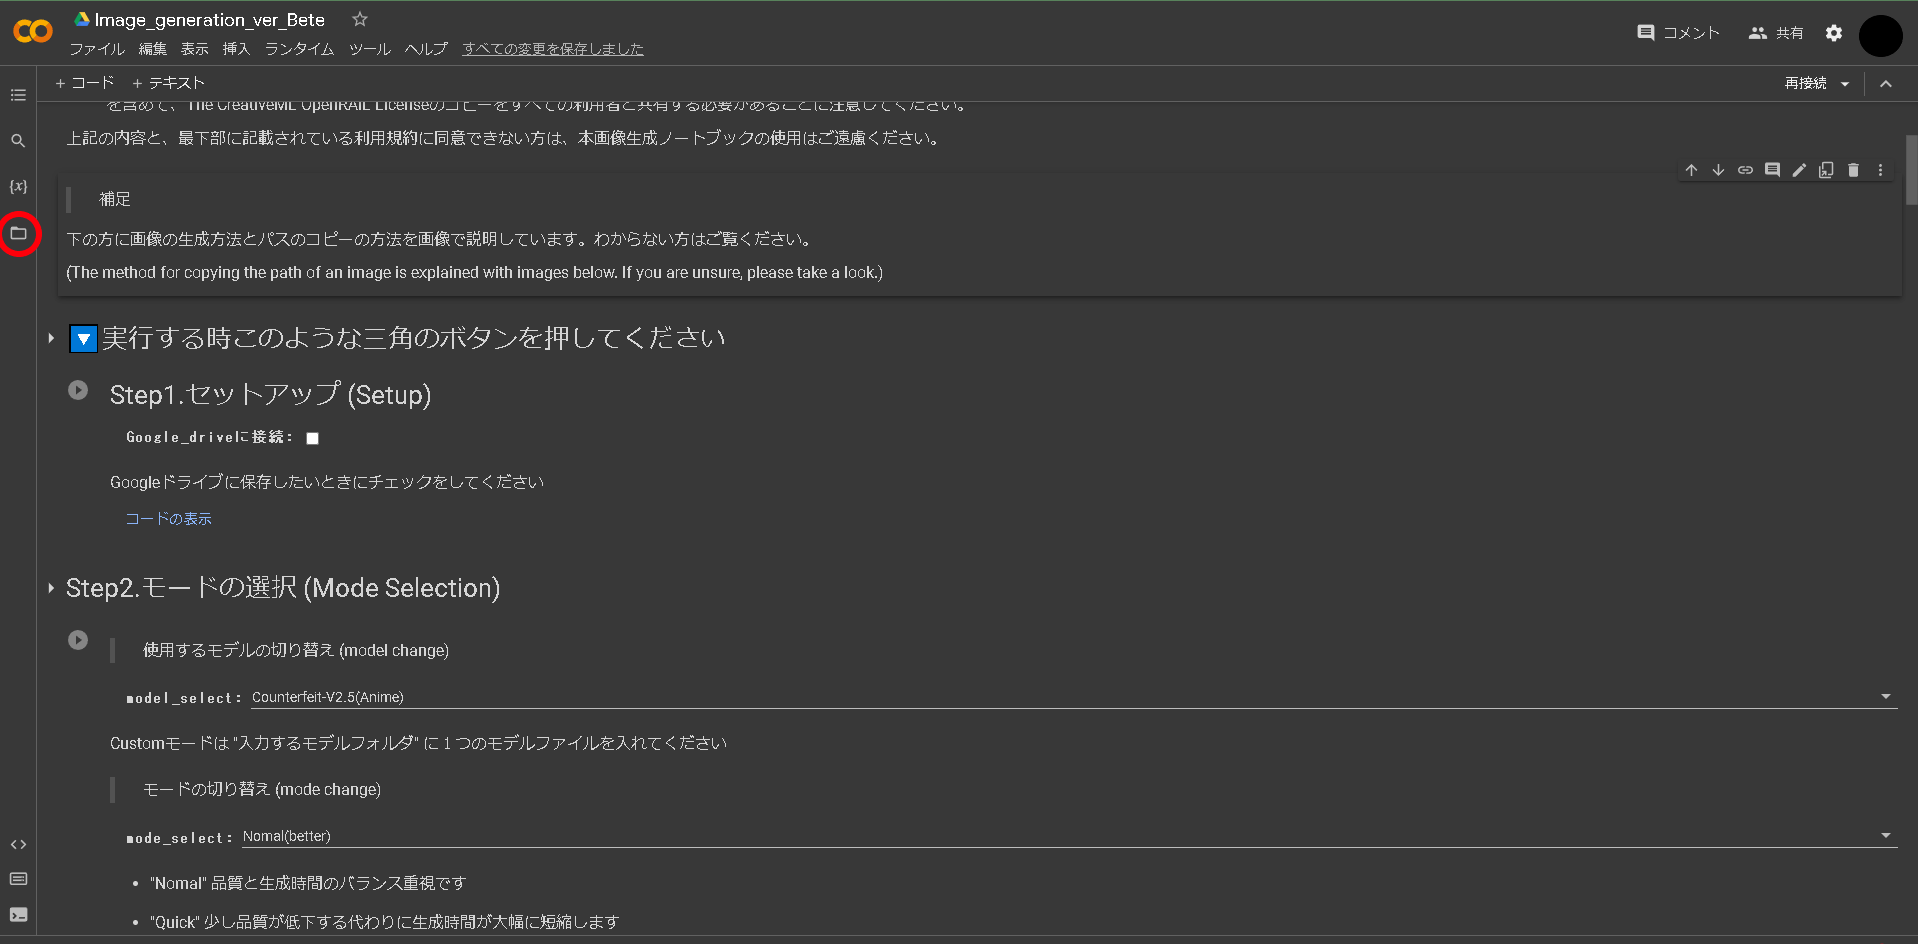

Step.2


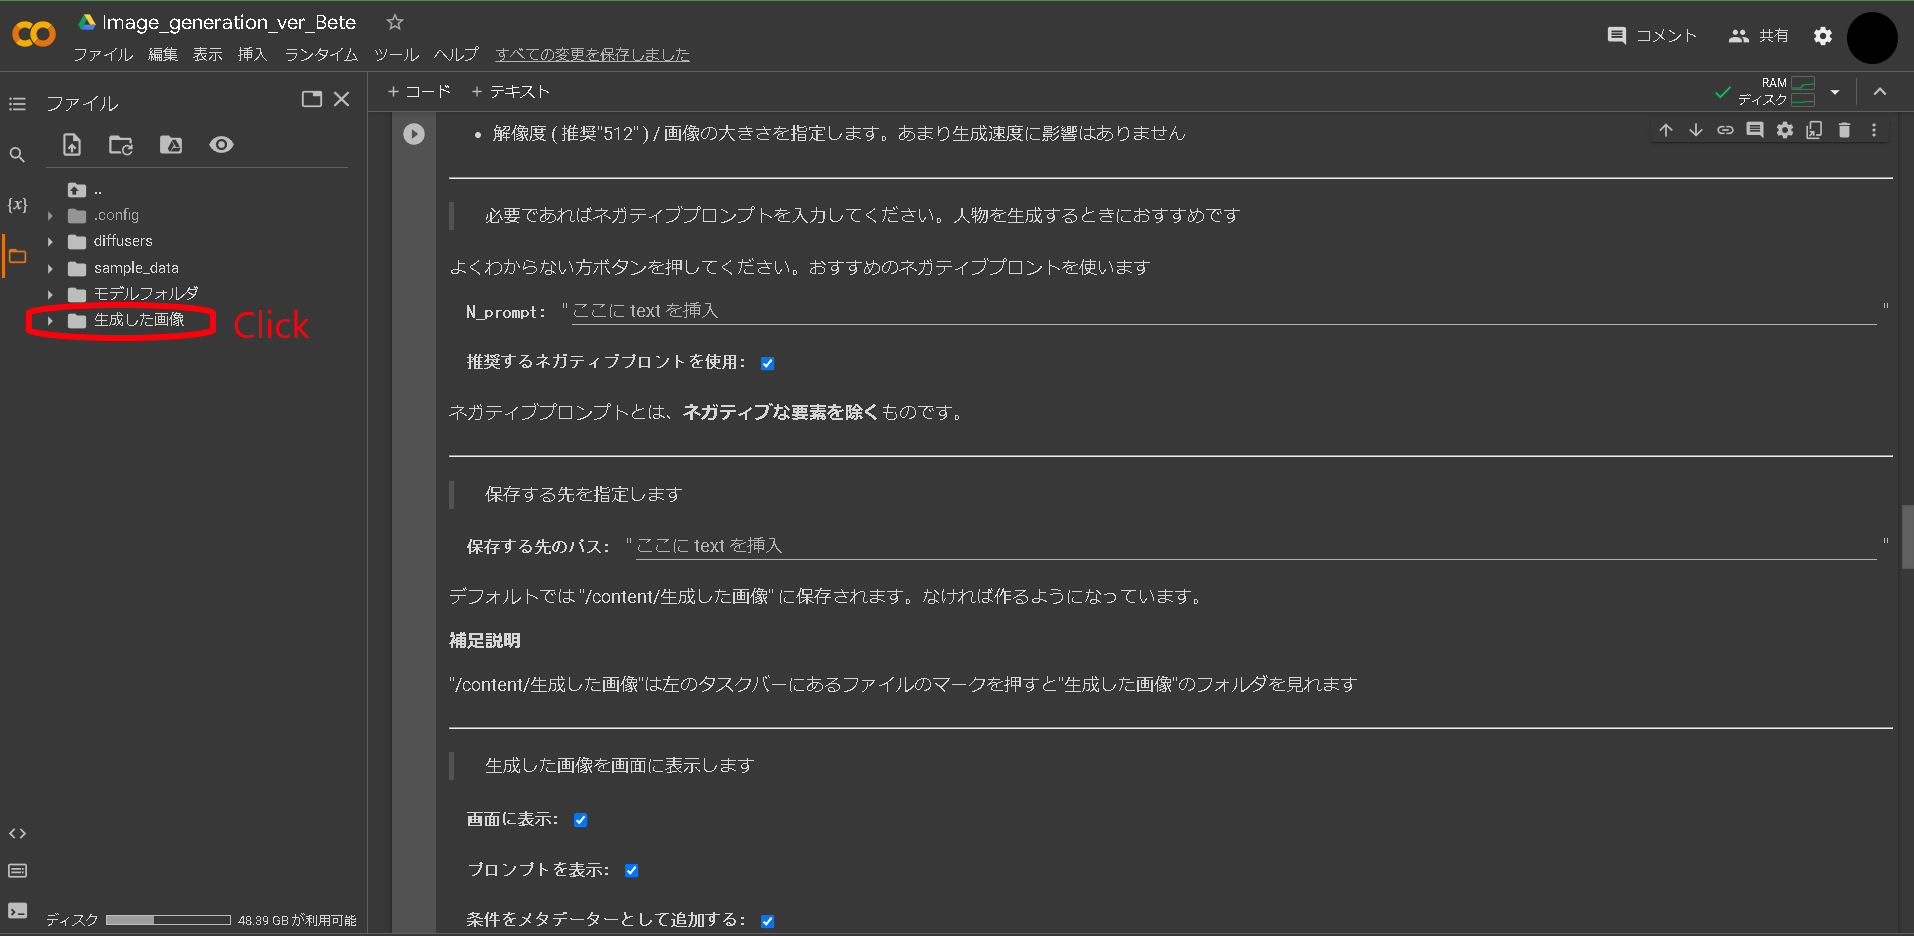

Step.3


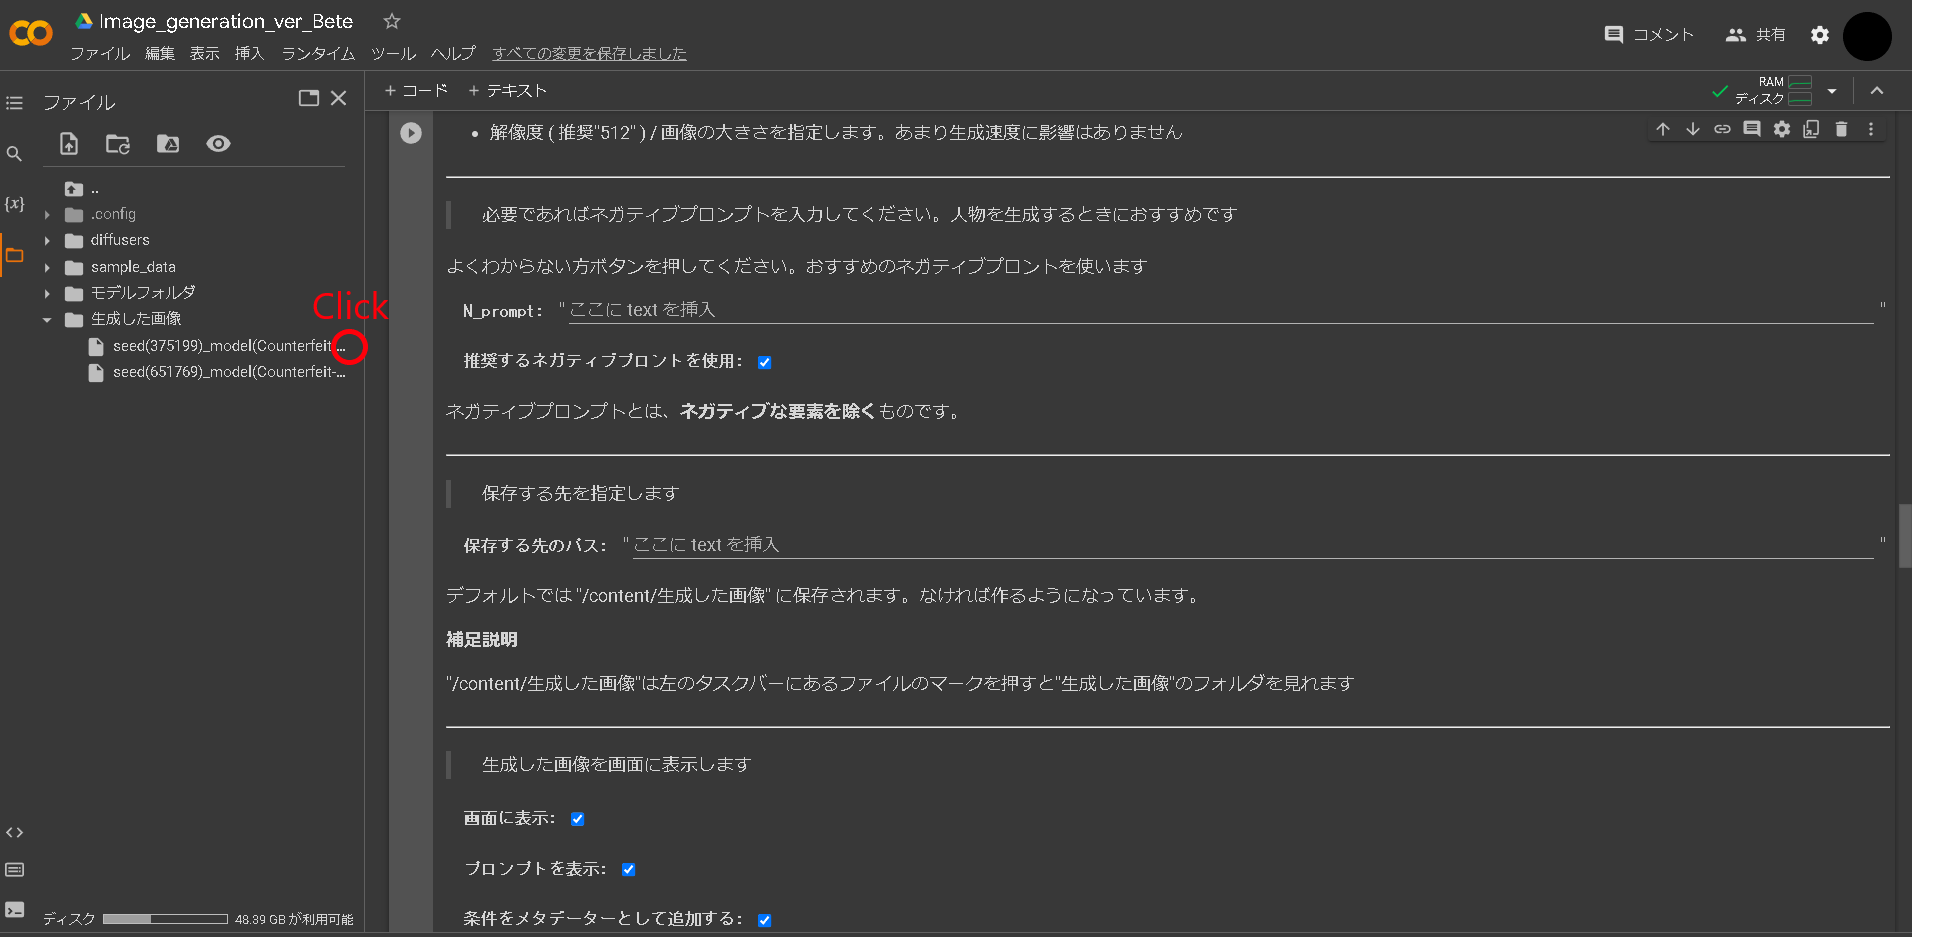

Step.4


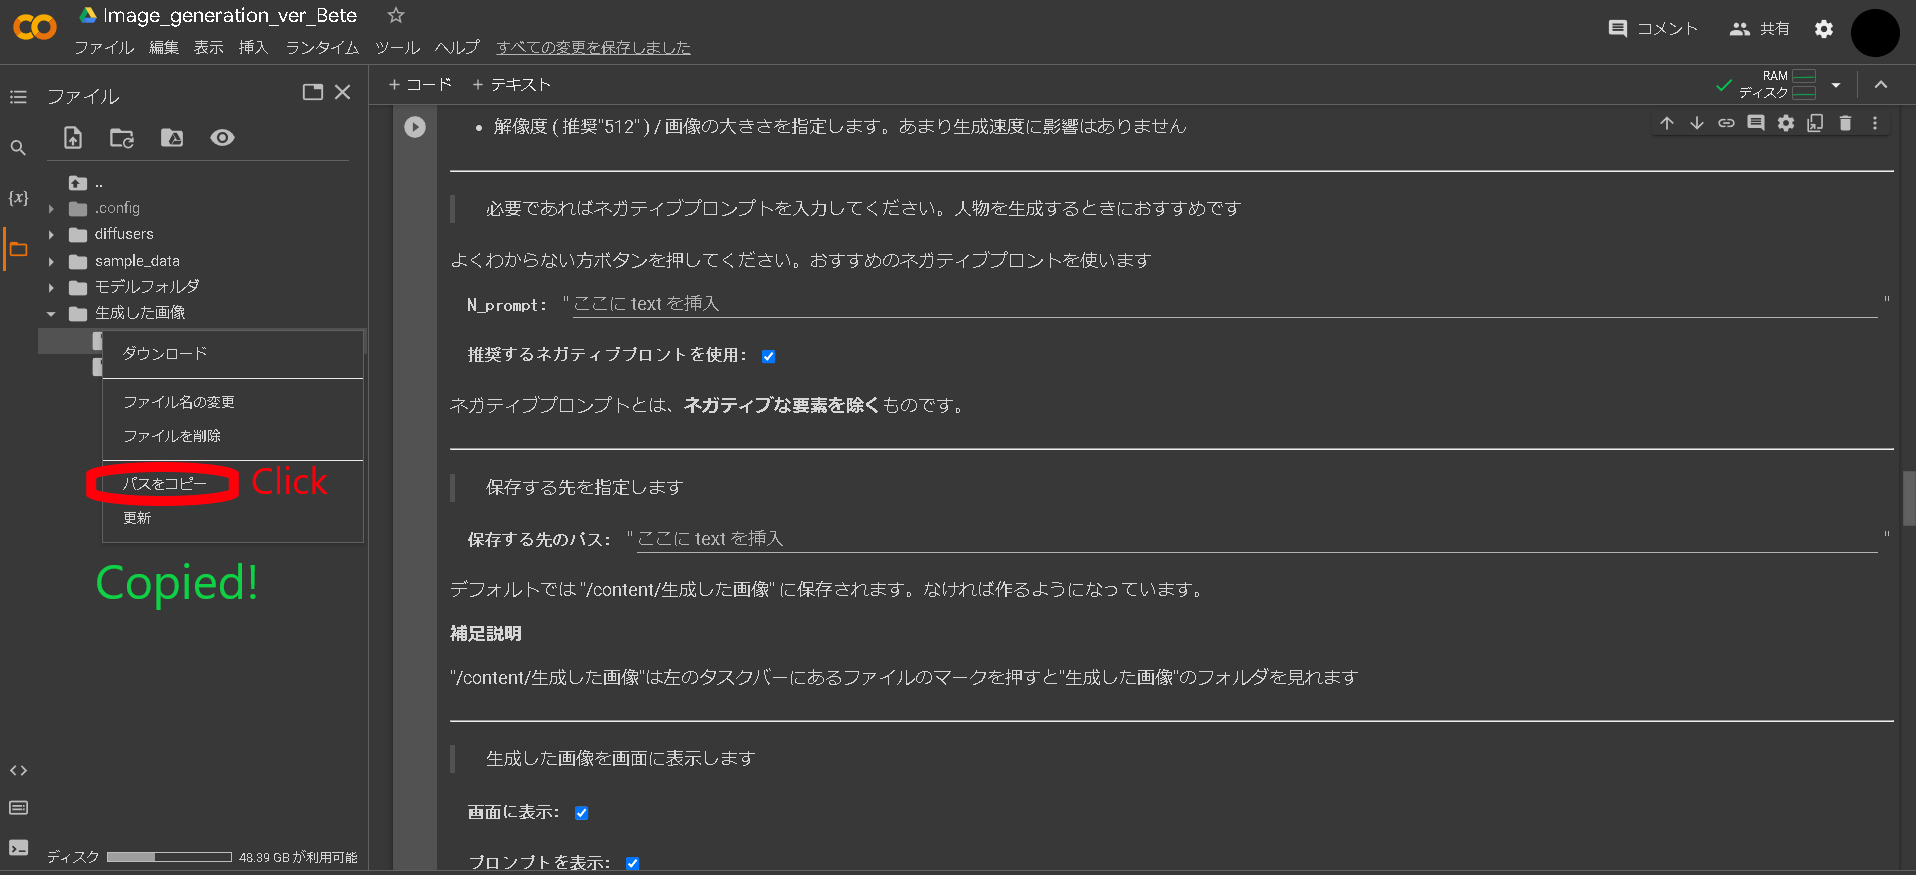

In [ ]:
#@title   {display-mode: "form"}
#@markdown #**How to copy the path of an image**

#@markdown Please modify the steps as needed
print("Step.1")
IM1=Image.open("/content/IMG_2085.png")
display(IM1)
print("Step.2")
IM2=Image.open("/content/IMG_2086.png")
display(IM2)
print("Step.3")
IM3=Image.open("/content/IMG_2087.png")
display(IM3)
print("Step.4")
IM4=Image.open("/content/IMG_2088.png")
display(IM4)

埋め込みが適用可能なのは、追加学習のベースモデルがstable diffusion-v1.5までのバージョンのみです。
現在の最新のバージョンであるstable diffusion-v2.1をベースモデルとしたものには使用できません。

#**Readme**(日本語版)
#利用規約

本画像生成ノーブックを使用するにあたって、利用規約の内容に全て同意したとみなします。

# **重要な注意点**：
* **商用利用はご遠慮ください。**
* **画像生成によって起こった問題について、私は一切責任を負いません。**

>免責事項:
*  使用にあたっては、自己責任でお願いします。
*  本モデルは予告なく変更・非公開・削除する可能性があります。
*  利用規約は予告なく変更する場合があります。
*  このモデルは、趣味で作成したものであり、商用利用などは意図していません。
*  使用にあたって発生した通信量、電気料金など金銭に関わるものの負担は追い兼ねます
*  Stable Diffusion-Ver2.1やその他の追加ライブラリに関する規約がある場合は、それらも確認することを強くお勧めします。
*  本プロジェクトを利用することにより生じた一切の問題について、私は一切責任を負いません。

ー本プロジェクトとは、本画像生成ノートブックや、githubのページなどをさします
___
#本プロジェクトの説明
Stable Diffusion-Ver2.1をベースにした画像生成ノートブックです。


>使用させていただいたライブラリ
- Stable Diffusion-ver2.1
- CLIP
- tqdm
- ftfy
- scipy
- regex
- torch
- diffusers
- accelerate
- safetensors
- transformers

※2023/5/12時点
---

謝辞

本画像生成ノートブックの作成にあたり、オープンソースのリソースやフリーのツールを使用させていただきました。個人的な利用でしたが、これらのリソースやツールがあったからこそ、本プロジェクトを実現することができました。
この場を借りて、オープンソースのコミュニティや、フリーのツールを提供してくださった方々に感謝の意を表します。素晴らしいツールや技術を提供してくださり、本プロジェクトを支援してくださったことに心から感謝いたします。

#**Readme(English_ver)**
# Terms of Use

By using this image generation notebook, you agree to all the contents of the Terms of Use.

Important Notice:
**Please refrain from using for commercial purposes.**
**I am not responsible for any problems caused by image generation.**

>Disclaimer:
* Please use it at your own risk.
* This NoteBook may be changed, unpublished, or deleted without notice.
* The terms of use may be changed without notice.
* This NoteBook is created for personal use and is not intended for commercial use.
* If there are terms and conditions for Stable Diffusion-Ver2.1 and other additional libraries, it is strongly recommended to confirm them as well.
* I am not responsible for any problems caused by using this project.

ー This project refers to the image generation notebook and GitHub pages.

---

# Description of this project

This is an image generation notebook based on Stable Diffusion-Ver2.1.

**Tools used**
* As of 2023/5/12

>**Libraries used**
- Stable Diffusion-ver2.1
- CLIP
- tqdm
- ftfy
- scipy
- regex
- torch
- diffusers
- accelerate
- safetensors
- transformers

---

# Acknowledgements

I used open source resources and free tools to create this image generation notebook. Although it was for personal use, it was only possible to realize this project because of these resources and tools.
I would like to express my gratitude to the open source community and those who provide free tools. I sincerely appreciate your support for this project by providing great tools and technologies.


もしかしたら日本文をいれるといいかもしれません。

masterpiece:2.0,best quality,high quality,cat ears,りんご,春,smail,cute,loli,fantasy art,beautiful,artstation,trending on artstation,alluring,masterpiece